In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab_Notebooks/perturbation_metric_test
!pip install anndata 
!pip install git+https://github.com/theislab/scgen.git
!pip install matplotlib
!pip install scanpy


Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/perturbation_metric_test
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 11.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/theislab/scgen.git to /tmp/pip-req-build-i8301jwy
  Running command git clone --filter=blob:none --quiet https://github.com/theislab/scgen.git /tmp/pip-req-build-i8301jwy
  Resolved https://github.com/theislab/scgen.git to commit 06084773e56cad0dec340138441dee47a39af752
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.3/330.3 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
import anndata
import scanpy as sc
import scgen
import pandas as pd  
import numpy as np
import torch
import torch.nn.functional as F

font = {'family' : 'Arial',
        'size'   : 14}
train = sc.read("./data/PapalexiSatija2021_eccite_RNA.h5ad")
train.layers['counts'] = train.X.copy()
sc.pp.log1p(train)
sc.pp.highly_variable_genes(train, n_top_genes=10, subset=True)
train.X = train.layers['counts']

from scvi import settings

def log_zinb_positive(
    x: torch.Tensor, mu: torch.Tensor, theta: torch.Tensor, pi: torch.Tensor, eps=1e-8
):
    """Log likelihood (scalar) of a minibatch according to a zinb model.
    Parameters
    ----------
    x
        Data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    pi
        logit of the dropout parameter (real support) (shape: minibatch x vars)
    eps
        numerical stability constant
    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """
    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(
            1, theta.size(0)
        )  # In this case, we reshape theta for broadcasting

    # Uses log(sigmoid(x)) = -softplus(-x)
    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)

    res = mul_case_zero + mul_case_non_zero

    return res

from typing import Union
import jax.numpy as jnp

def log_nb_positive(
    x: Union[torch.Tensor, jnp.ndarray],
    mu: Union[torch.Tensor, jnp.ndarray],
    theta: Union[torch.Tensor, jnp.ndarray],
    eps: float = 1e-8,
    log_fn: callable = torch.log,
    lgamma_fn: callable = torch.lgamma,
):
    """Log likelihood (scalar) of a minibatch according to a nb model.
    Parameters
    ----------
    x
        data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    log_fn
        log function
    lgamma_fn
        log gamma function
    """
    log = log_fn
    lgamma = lgamma_fn
    log_theta_mu_eps = log(theta + mu + eps)
    res = (
        theta * (log(theta + eps) - log_theta_mu_eps)
        + x * (log(mu + eps) - log_theta_mu_eps)
        + lgamma(x + theta)
        - lgamma(theta)
        - lgamma(x + 1)
    )

    return res

In [3]:
from statsmodels.discrete.count_model import (ZeroInflatedNegativeBinomialP, ZeroInflatedPoisson,
                                              ZeroInflatedGeneralizedPoisson)

import matplotlib.pyplot as plt
import statsmodels.api as sm 
from joblib import Parallel,delayed
import torch
import torch.nn.functional as F
def data_prep(adata,conditions=None,sample_ctrl=False):
    """
    param
    -----------
    adata
    return_mean: bool variable True if we want to compute mean of sampled data per cell to
    find statistic between mean of data from sample1 and sample2
    output: the sampled data from sample1 and sample2 of type array
    """
    control = adata[adata.obs["perturbation"] == conditions["x"]]
    stim = adata[adata.obs["perturbation"] == conditions["y"]]
    
    #fix the number of rows of sampled data as the minimum number of rows between sample1,sample2
    n=np.minimum(control.shape[0],stim.shape[0])
    
    x,_ = sample_obs(control,n)
    y,_ = sample_obs(stim,n)
        
    x=x.toarray()
    y=y.toarray() 
    
    return x,y

def dist_based(x,y):
    """
    transpose the data so that we can compute static between genes (columns)
    """
    m=np.minimum(x.shape[0],y.shape[0])
    x=x.T[:,:m]#delete .toarray()
    y=y.T[:,:m]
    return x,y

def sample_obs(adata,size_n):
    """
    params 
    -------------
    sample for all control and stim pairs 
    size_n:the number of rows we will consider in comparison
    output x,y in sparse matrix form
    which is sample1 and sample2 drawn from two specified codition
    """

    x = adata.X
    #print(x.shape)(16893, 6998)
    n_rows=x.shape[0]
    
    df = pd.DataFrame({'x':np.arange(n_rows)})
    #shuffle the data index
    x_sample1=df['x'].sample(frac=1, replace=False).values[:size_n]
    x_sample2=df['x'].sample(frac=1, replace=False).values[:size_n]
    
    return x[x_sample1,:], x[x_sample2,:]

import random

def subset(alist, idxs):
    '''
        use idxs to subset alist
        alist: list
        idxs: list
    '''
    sub_list = []
    for idx in idxs:
        sub_list.append(alist[idx])

    return sub_list

def split_list(alist, group_num=3, shuffle=True, retain_left=False):
    '''
        split data into 3 subset and let each subset contains the len(alist)//group number of elements
        shuffle: whether shuffle the splitted data, default: True
        retain_left: if list alist is splited into the number of group_num subset and there is some element remain，
        whether take the remaining elements as a subset
    '''

    index = list(range(len(alist))) 

    
    if shuffle: 
        random.shuffle(index) 
    
    elem_num = len(alist) // group_num 
    sub_lists = {}
    
   
    for idx in range(group_num):
        start, end = idx*elem_num, (idx+1)*elem_num
        sub_lists[str(idx)] = subset(alist, index[start:end])
    
  
    if retain_left and group_num * elem_num != len(index): 
        sub_lists[str(idx+1)] = subset(alist, index[end:])
    
    return sub_lists



def sample_control_control(adata,size_n):
    """
    the sampling for ctrl and ctrl
    split the data into three samples
    shuffle the three samples
    return two data set have maximum between-sample distance
    
    """
    x = adata.X
    n_rows=x.shape[0]
    index_dict=split_list(range(n_rows))# in form {0: [1,2,3],1:[3,44,2...],3:[]}
    sample1=x[index_dict['0'],:size_n].toarray()
    sample2=x[index_dict['1'],:size_n].toarray()
    sample3=x[index_dict['2'],:size_n].toarray() 
    
    pairs={}
    pairs[0]=(sample1,sample2)
    pairs[1]=(sample1,sample3)
    pairs[2]=(sample2,sample3)
    return pairs 

def process_item_alpha(i,x):
    # plt.hist(x[i],bins=30)
    # plt.yscale('log')
    # plt.show()
    
    # print(all(elem == 0 for elem in x[i]))
    print("gene",i)

    if all(elem == 0 for elem in x[i]):
        return None 

    else:
        one=np.ones_like(x[i])
        model=sm.NegativeBinomialP(x[i],one).fit()
        if model.params[1]>0:
            # print(model.summary())
            return model.params[1]
        else:
            return None 
    
def process_item_const(i,x):
    # plt.hist(x[i],bins=30)
    # plt.yscale('log')
    # plt.show()
    
    # print(all(elem == 0 for elem in x[i]))
    print("gene",i)

    if all(elem == 0 for elem in x[i]):
        return None 

    else:
        one=np.ones_like(x[i])
        model=sm.NegativeBinomialP(x[i],one).fit()
        if model.params[1]>0:
        # print(model.summary())
            return model.params[0]
        else:
            return None 

def process_per_batch(x,num_from,num_to):
    x=x[num_from:num_to,:]

    alpha=Parallel(n_jobs=-1,backend="multiprocessing")(
        delayed(process_item_alpha)(i,x)for i in range(x.shape[0])
    )

    const=Parallel(n_jobs=-1,backend="multiprocessing")(
        delayed(process_item_const)(i,x)for i in range(x.shape[0])
    ) 
    return alpha,const    


In [9]:
def test_get_data(zinb,train,metric_str):
    """
    fn: the function to get datasets after sampling before we fit the gene in sample1 and sample2
    
    """
    list_stim=list(train.obs['perturbation'].unique())
    list_stim.remove('control')
    conditions={"x":"control","y":"stim"}
    difference=[]
    if_stim=['stim']*len(list_stim)
    # sample1 is always sampled from control and sample2 is sampled from 99 different stim 
    #use prep_data to sample respectively 
     
    for stim in list_stim:
        conditions["y"]=str(stim)
        # print(conditions)
        out=zinb(train,conditions,str(stim))
        print("data:",out)
        difference.append(out)
    
    #lastly,for (ctrl,ctrl) where we apply a different sampling method, get three points 
    conditions["y"]="control"
    control = train[train.obs["perturbation"] == conditions["x"]]
    print(conditions)
    pairs=sample_control_control(control,control.shape[0])
     
    for i in range(3):
        (x,y)=pairs[i]
        out=zinb(adata=train,conditions=conditions,stim_str='control'+str(i),sample_ctrl=True,ctrl1=x,ctrl2=y)
        print(" data for (contrl, control):",out)
        difference.append(out)

    zero=['control']*3
    if_stim=if_stim + zero
    metric=[metric_str]*len(if_stim)
        
    return difference,if_stim,metric  

def compute_log_zinb(x,const_x,alpha_x):
    mu=np.exp(const_x)
    theta=1/alpha_x
    # p=1/(1+theta)*mu
    p=mu*theta/(1+theta)
    nan=0
    if 1-p<=0 or p<=0:
      most_frequent=0
      nan+=1
    else:
      logit=np.log((1-p)/p)
      #x_val=log_zinb_positive(torch.tensor(x),torch.tensor(mu),torch.tensor(theta),torch.tensor(logit))
      x_val=log_nb_positive(torch.tensor(x),torch.tensor(mu),torch.tensor(theta))
      most_frequent=torch.mode(x_val).values.item()
    return most_frequent,nan 

def zinb_fit_ctrl(adata, conditions,stim_str,sample_ctrl=False,ctrl1=None,ctrl2=None):
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,conditions)
        
    x,y=dist_based(x,y)
    alpha_x, const_x =process_per_batch(x,0,99)

    out=0
    count=0
    for i in range(x.shape[0]):
        if all(elem == 0 for elem in x[i]):
            continue
        if all(elem == 0 for elem in y[i]):
            continue 
        else:
          NoneType = type(None)
          if isinstance(const_x[i], NoneType) or isinstance(alpha_x[i], NoneType):
              continue 
          else:
              count+=1
              output,nan=compute_log_zinb(y[i],const_x[i],alpha_x[i])
              out+=output
              count-=nan
    
    if count==0:
      count=1# to avoid divison by zero     
            
    return out/count 

differece0,if_stim0,metric0=test_get_data(zinb_fit_ctrl,train,'zinb')

gene gene0
 1
Optimization terminated successfully.gene
          Current function value: 0.1557952
         Iterations: 2

         Function evaluations: 12         Gradient evaluations: 12

Optimization terminated successfully.
         Current function value: 0.024750
         Iterations: 0gene 
3
         Function evaluations: 1Optimization terminated successfully.
         Gradient evaluations: 1
         Current function value: 0.261463

         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 12
gene          Gradient evaluations: 124

Optimization terminated successfully.gene 6

         Current function value: 0.197275
         Iterations: 4Optimization terminated successfully.

         Current function value: 0.149245         Function evaluations: 11

         Iterations: 3
         Function evaluations: 12         Gradient evaluations: 11
gene
          Gradient evaluations: 12
gene5 7

geneOptimization terminated successfully. 8

         Current function value: 0.548923
Optimization terminated successfully.         Iterations: 2

         Current function value: 0.192518         Function evaluations: 11

         Iterations: 5         Gradient evaluations: 11
gene
 9
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.038915
         Iterations: 3
         Function evaluations: 14
         Gradient evaluations: 14
genegene  01

geneOptimization term

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 4
3
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.261463

         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 12
gene 6
         Current function value: 0.197275Optimization terminated successfully.
         Current function value: 0.149245

         Iterations: 4
         Iterations: 3
         Function evaluations: 11         Function evaluations: 12
         Gradient evaluations: 12

         Gradient evaluations: 11gene 
7
gene 5gene
 Optimization terminated successfully.8

         Current function value: 0.548923
         Iterations: 2
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.gene 
9         Current function value: 0.192518

         Iterations: 5
Optimization terminated successfully.
         Function evaluations: 13
         Current function value: 0.038915         Gradient evaluations: 13

         Iterations: 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.323903

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu



         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Function evaluations: 10
         Gradient evaluations: 10
gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
Optimization terminated successfully.
         Function evaluations: 112
         Current function value: 0.434605         Gradient evaluations: 112

         Iterations: 6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Function evaluations: 12
          Gradient evaluations: 126

gene 5Optimization terminated successfully.

         Current function value: 0.162468
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.063908
         Iterations: 5
         Function evaluations: 14
         Gradient evaluations: 14
gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm 

         Current function value: 0.741298
         Iterations: 1
         Function evaluations: 124

         Current function value: 0.044014

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
         Iterations: 1 
9         Function evaluations: 124

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 1 
0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


2
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


Optimization terminated successfully.
         Current function value: 0.323903
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
 4
         Iterations: 1
         Function evaluations: 112Optimization terminated successfully.

         Current function value: 0.434605
         Iterations: 6
         Gradient evaluations: 112         Function evaluations: 12

         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene 6
5Optimization terminated successfully.

         Current function value: 0.162468

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 4
         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 7
Optimization terminated successfully.
         Current function value: 0.063908
         Iterations: 5
         Function evaluations: 14
         Gradient evaluations: 14
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.741298


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.044014
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.041172186533610024
gene gene0
 1
geneOptimization terminated successfully.
 2
gene 3
         Current function value: 0.195088
         Iterations: 4Optimization terminated successfully.
         Current function value: 0.328900

         Function evaluations: 10
         Iterations: 2
         Function evaluations: 10         Gradient evaluations: 10
         Gradient evaluations: 10
gene
 gene4 
6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.083192

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 5
         Function evaluations: 14


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 14
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Current function value: 0.832426

         Iterations: 4         Iterations: 1

         Function evaluations: 11
         Function evaluations: 112         Gradient evaluations: 11

         Gradient evaluations: 112
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
genegene 1 
0
gene Optimization terminated successfully.2

gene 3
         Current function value: 0.195088
Optimization terminated successfully.
         Current function value: 0.328900
         Iterations: 4         Iterations: 2

         Function evaluations: 10         Function evaluations: 10

         Gradient evaluations: 10         Gradient evaluations: 10

genegene  46

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.083192
         Iterations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 14
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



Optimization terminated successfully.
         Current function value: 0.832426
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.061027348041534424
gene 0
Optimization terminated successfully.
         Current function value: 0.116362
         Iterations: 0
         Function evaluations: 1
gene         Gradient evaluations: 1
gene 2 
1gene 
3
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.309027

         Current function value: 0.017441         Iterations: 4

         Iterations: 0
         Function evaluations: 13
         Function evaluations: 1         Gradient evaluations: 13

gene          Gradient evaluations: 14

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Current function value: 0.437613 
6         Iterations: 3

         Function evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 5
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.509032
         Iterations: 3
         Function evaluations: 9
         Gradient evaluations: 9
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan
         Current function value: 0.164573         Iterations: 1

         Iterations: 2         Function evaluations: 112

         Function evaluations: 10         Gradient evaluations: 112

         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  79
Optimization terminated successfully.

         Current function value: 0.017441

         Iterations: 0
         Function evaluations: 1         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 0
Optimization terminated successfully.
         Current function value: 0.116362
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
gene 1gene
Optimization terminated successfully.
          Current function value: 0.0174412

         Iterations: 0gene
          Function evaluations: 13

         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.gene
          Current function value: 0.3090274

         Iterations: 4
Optimization terminated successfully.         Function evaluations: 13

         Current function value: 0.437613         Gradient evaluations: 13

         Iterations: 3gene
 6         Function evaluations: 10

         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


5
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.509032

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 3
         Function evaluations: 9
         Gradient evaluations: 9
gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.164573         Current function value: nan

         Iterations: 2         Iterations: 1

         Function evaluations: 10         Function evaluations: 112

         Gradient evaluations: 10         Gradient evaluations: 112

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene9 
7
Optimization terminated successfully.
         Current function value: 0.017441
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.04689558347066244
gene gene0
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.210884

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 13
         Gradient evaluations: 13
gene Warning: Desired error not necessarily achieved due to precision loss.2
         Current function value: 0.037006

         Iterations: 1
         Function evaluations: 124gene
         Gradient evaluations: 112 
3

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene 4
         Current function value: 0.307276
         Iterations: 3

         Function evaluations: 10
         Gradient evaluations: 10
geneOptimization terminated successfully.6 

Optimization terminated successfully.
         Current function value: 0.077862
         Iterations: 3
         Current function value: 0.284796         Function evaluations: 12

         Gradient evaluations: 12

gene         Iterations: 3 7
         Function evaluations: 11gene
          Gradient evaluations: 118

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
 

         Current function value: 0.556196
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 124
         Gradient evaluations: 112
         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Function evaluations: 112gene 9



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/stats

         Current function value: 0.037006
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 Optimization terminated successfully.1

         Current function value: 0.210884
         Iterations: 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 13
         Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



Optimization terminated successfully.
         Current function value: 0.307276Warning: Desired error not necessarily achieved due to precision loss.
         Iterations: 3
         Function evaluations: 10

         Current function value: 0.037006
         Iterations: 1         Gradient evaluations: 10
         Function evaluations: 124
         Gradient evaluations: 112

gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.2847966

Optimization terminated successfully.         Iterations: 3
         Function evaluations: 11

         Current function value: 0.077862         Gradient evaluations: 11

         Iterations: 3gene
          Function evaluations: 12
         Gradient evaluations: 12
gene 7
gene5 8



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.556196
         Iterations: 1Warning: Desired error not necessarily achieved due to precision loss.
         Function evaluations: 124
         Gradient evaluations: 112

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9         Iterations: 1
         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/stats

         Current function value: 0.037006
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.04093246459960938
gene 0
Optimization terminated successfully.
         Current function value: 0.124249
gene         Iterations: 3
         Function evaluations: 12
          Gradient evaluations: 121
gene
gene 2 
3Optimization terminated successfully.

         Current function value: 0.023482
Optimization terminated successfully.         Iterations: 0

         Function evaluations: 1         Current function value: 0.316164
         Iterations: 3
         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 10gene
         Gradient evaluations: 10 
4gene
 6
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.380916         Current function value: 0.097805

         Iterations: 2         Iterations: 3

         Function evaluations: 12
         Function evaluations: 12         Gradient evaluations: 12

         Gradient evaluations: 12gene
 5gene
 Optimization terminated successfully.
         Current function value: 0.5055657

         Iterations: 5gene 
8         Function evaluations: 11

Optimization terminated successfully.         Gradient evaluations: 11

         Current function value: 0.170383gene
          Iterations: 19

         Function evaluations: 10
Optimization terminated successfully.         Gradient evaluations: 10

         Current function value: 0.023482
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene 0 1

gene 2Optimization terminated successfully.

         Current function value: 0.124249         Iterations: 3
         Function evaluations: 12

         Gradient evaluations: 12
Optimization terminated successfully.gene 3
         Current function value: 0.023482

         Iterations: 0
         Function evaluations: 1
Optimization terminated successfully.
         Gradient evaluations: 1         Current function value: 0.316164

         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 4         Function evaluations: 10

         Gradient evaluations: 10
Optimization terminated successfully.gene
         Current function value: 0.380916 
6         Iterations: 2

Optimization terminated successfully.         Function evaluations: 12
         Current function value: 0.097805

         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 12
         Gradient evaluations: 12gene 7
gene 
8gene
 5
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.505565

         Current function value: 0.170383         Iterations: 5

         Iterations: 1         Function evaluations: 11
         Function evaluations: 10
         Gradient evaluations: 10

         Gradient evaluations: 11gene
 9
Optimization terminated successfully.
         Current function value: 0.023482
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.04322389193943569
genegene  01

gene 2
Optimization terminated successfully.gene
         Current function value: 0.203795
          Iterations: 53

         Function evaluations: 13
         Gradient evaluations: 13Optimization terminated successfully.

         Current function value: 0.346932
         Iterations: 5gene 4

Optimization terminated successfully.         Function evaluations: 12

         Gradient evaluations: 12
         Current function value: 0.415930 gene
         Iterations: 46

         Function evaluations: 10
Optimization terminated successfully.         Gradient evaluations: 10

gene         Current function value: 0.091999
          Iterations: 55

Optimization terminated successfully.
         Function evaluations: 13         Current function value: 0.222384

         Iterations: 4         Gradient evaluations: 13

gene         Function evaluations: 11 
         Gradient evaluations: 117

genegene 8
 9Optimization terminated successfully.

         C

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene
 gene 34

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.316968         Current function value: 0.289182

         Iterations: 0         Iterations: 3
         Function evaluations: 1

         Gradient evaluations: 1
         Function evaluations: 11
gene         Gradient evaluations: 11 
5gene 
6
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.483029

         Iterations: 3
         Current function value: 0.183839         Function evaluations: 9

         Gradient evaluations: 9         Iterations: 2

gene         Function evaluations: 10 
         Gradient evaluations: 10
8gene 
7
Optimization terminated successfully.gene 
9         Current function value: 0.190833
         Iterations: 2
         Function evaluations: 13

         Gradient evaluations: 13
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.122712
     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


2gene 
3
gene Optimization terminated successfully.4
Optimization terminated successfully.
         Current function value: 0.289182

         Iterations: 3
         Current function value: 0.316968         Function evaluations: 11

         Iterations: 0         Gradient evaluations: 11

         Function evaluations: 1gene
          Gradient evaluations: 16

gene Optimization terminated successfully.5

         Current function value: 0.183839
Optimization terminated successfully.         Iterations: 2

         Current function value: 0.483029         Function evaluations: 10

         Iterations: 3         Gradient evaluations: 10

         Function evaluations: 9gene
          Gradient evaluations: 97

genegene  89

Optimization terminated successfully.
         Current function value: 0.190833
         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13
data: -0.04099113600594657
genegene 1
 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.162773
         Iterations: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Gradient evaluations: 11
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.041821

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood opt

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 4

         Current function value: 0.313313
         Current function value: 0.362661
         Iterations: 1         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
         Function evaluations: 124

         Gradient evaluations: 112
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5gene
 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.188465

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7
gene 8
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Iterations: 2
         Function evaluations: 121

         Gradient evaluations: 121


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.070368

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 9         Iterations: 1

Optimization terminated successfully.         Function evaluations: 11
         Gradient evaluations: 11
         Current function value: 0.023342

         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 0
gene Optimization terminated successfully.1

         Current function value: 0.162773
         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 2
gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.041821


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.362661

         Iterations: 4
         Function evaluations: 11         Gradient evaluations: 11
gene 5         Current function value: 0.313313

         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


Optimization terminated successfully.
         Current function value: 0.188465
         Iterations: 3
         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7         Current function value: nan

gene         Iterations: 2 
8         Function evaluations: 121

Optimization terminated successfully.         Gradient evaluations: 121

         Current function value: 0.070368

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 11 
9         Gradient evaluations: 11
Optimization terminated successfully.

         Current function value: 0.023342
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.027683019638061523
gene 0gene
 1
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.027099
         Iterations: 0
         Function evaluations: 1

         Current function value: 0.124333
         Gradient evaluations: 1         Iterations: 3

         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Gradient evaluations: 11 
2gene
 gene 3
4Optimization terminated successfully.

Optimization terminated successfully.
         Current function value: 0.384782         Current function value: 0.264654
         Iterations: 4
         Function evaluations: 11

         Gradient evaluations: 11         Iterations: 2
gene
          Function evaluations: 12
5         Gradient evaluations: 12
gene
Optimization terminated successfully. 6

         Current function value: 0.390851
Optimization terminated successfully.         Iterations: 2
         Current function value: 0.027099
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1

         Function evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '




         Gradient evaluations: 9genegene  78

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.040327         Current function value: 0.027099

         Iterations: 2         Iterations: 0

         Function evaluations: 1         Function evaluations: 13

         Gradient evaluations: 1         Gradient evaluations: 13



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 9
genegene  0
1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.027099
         Current function value: 0.124333

         Iterations: 3         Iterations: 0

         Function evaluations: 1         Function evaluations: 11

         Gradient evaluations: 1         Gradient evaluations: 11



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene  23

gene Optimization terminated successfully.
4         Current function value: 0.264654

         Iterations: 2Optimization terminated successfully.

         Function evaluations: 12         Current function value: 0.384782

         Gradient evaluations: 12
         Iterations: 4gene
          Function evaluations: 116

         Gradient evaluations: 11Optimization terminated successfully.

gene         Current function value: 0.027099 5

         Iterations: 0Optimization terminated successfully.

         Function evaluations: 1         Current function value: 0.390851

         Gradient evaluations: 1         Iterations: 2



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene          Function evaluations: 97

         Gradient evaluations: 9
Optimization terminated successfully.
gene         Current function value: 0.040327 
8         Iterations: 2

Optimization terminated successfully.         Function evaluations: 13

         Current function value: 0.027099         Gradient evaluations: 13

         Iterations: 0gene 
9
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.031885385513305664
genegene  01

Optimization terminated successfully.
         Current function value: 0.026264
Optimization terminated successfully.         Iterations: 0

         Current function value: 0.076932         Function evaluations: 1
         Iterations: 5
         Function evaluations: 14
         Gradient evaluations: 14

         Gradient evaluations: 1gene
 2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



genegene  43

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.434551

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 3
         Function evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



Optimization terminated successfully.
         Current function value: 0.533319
         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 14Warning: Desired error not necessarily achieved due to precision loss.

         Gradient evaluations: 14         Current function value: nan

         Iterations: 2

         Function evaluations: 123
         Gradient evaluations: 123gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6gene 
8Optimization terminated successfully.

         Current function value: 0.155277Optimization terminated successfully.

         Iterations: 3         Current function value: 0.113055

         Function evaluations: 9
         Iterations: 3
         Gradient evaluations: 9
         Function evaluations: 12
gene         Gradient evaluations: 12 
7
gene Optimization terminated successfully.9

         Current function value: 0.039114
         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13
genegene  10

Optimization terminated successfully.
         Current function value: 0.076932Optimization terminated successfully.

         Current function value: 0.026264
         Iterations: 0         Iterations: 5

         Function evaluations: 1         Function evaluations: 14

         Gradient evaluations: 1         Gradient evaluations: 14



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene  23

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.434551

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu



         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Function evaluations: 9
         Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: nan
         Iterations: 2Optimization terminated successfully.

         Current function value: 0.533319
         Iterations: 4         Function evaluations: 123

         Function evaluations: 14
         Gradient evaluations: 14
         Gradient evaluations: 123gene 
6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
8
         Current function value: 0.155277Optimization terminated successfully.

         Current function value: 0.113055         Iterations: 3

         Iterations: 3
         Function evaluations: 12         Function evaluations: 9
         Gradient evaluations: 12
         Gradient evaluations: 9

genegene  97

Optimization terminated successfully.
         Current function value: 0.039114
         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13
data: -0.04266653458277384
gene gene0 
1
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.094965

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 4
         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.038575

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Warning: Desired error not necessarily achieved due to precision loss.3

         Current function value: 0.038575
Optimization terminated successfully.         Iterations: 1

         Current function value: 0.237257         Function evaluations: 124

         Iterations: 5         Gradient evaluations: 112

         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 11gene
 gene4 
6Optimization terminated successfully.

         Current function value: 0.200559Optimization terminated successfully.

         Iterations: 2         Current function value: 0.199412

         Function evaluations: 11         Iterations: 7

         Gradient evaluations: 11         Function evaluations: 14

gene         Gradient evaluations: 14 
gene5
 Optimization terminated successfully.7

         Current function value: 0.492010
Optimization terminated successfully.         Iterations: 3

         Current function value: 0.057603         Function evaluations: 9

         Gradient evaluations: 9         Iterations: 4

         Function evaluations: 14gene
         Gradient evaluations: 14 8

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.094965

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 4
         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.038575

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.038575Optimization terminated successfully.

         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112
         Current function value: 0.237257

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 4
         Iterations: 5Optimization terminated successfully.
         Current function value: 0.200559
         Iterations: 2
         Function evaluations: 11

         Gradient evaluations: 11
gene         Function evaluations: 11
         Gradient evaluations: 11
 gene5
 6
Optimization terminated successfully.
         Current function value: 0.492010
Optimization terminated successfully.         Iterations: 3
         Function evaluations: 9

         Current function value: 0.199412
         Iterations: 7
         Gradient evaluations: 9         Function evaluations: 14
gene
          Gradient evaluations: 148



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.057603

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Function evaluations: 14
         Gradient evaluations: 14
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.037433465321858726
gene gene0 
1
Optimization terminated successfully.
         Current function value: 0.109155
         Iterations: 0Optimization terminated successfully.
         Function evaluations: 1

         Gradient evaluations: 1
         Current function value: 0.027687gene
 2
Optimization terminated successfully.         Iterations: 0
         Current function value: 0.027687

         Iterations: 0         Function evaluations: 1

         Function evaluations: 1         Gradient evaluations: 1
         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene  4
3
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.391185
         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 13
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.547474Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan
         Iterations: 5         Iterations: 2

         Function evaluations: 11         Function evaluations: 123

         Gradient evaluations: 11         Gradient evaluations: 123

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Current function value: 0.130748
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene         Current function value: nan 9

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.027687
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene gene0 
1
Optimization terminated successfully.
         Current function value: 0.027687
Optimization terminated successfully.
         Iterations: 0         Current function value: 0.109155

         Iterations: 0         Function evaluations: 1
         Function evaluations: 1

         Gradient evaluations: 1         Gradient evaluations: 1

gene 2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



Optimization terminated successfully.gene
         Current function value: 0.027687 
3         Iterations: 0



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 4
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.391185


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 4Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan         Function evaluations: 13
         Iterations: 2

         Function evaluations: 123         Gradient evaluations: 13

gene         Gradient evaluations: 123 
5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.5474746

         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


Optimization terminated successfully.
         Current function value: 0.130748
         Iterations: 4
         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 12Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: nan

gene         Iterations: 1
          Function evaluations: 112
9         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.027687
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.035517726625714986
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm 

         Current function value: 0.035569

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 124
         Current function value: nan

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 3         Function evaluations: 112

Optimization terminated successfully.         Gradient evaluations: 112
         Current function value: 0.166712

         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Gradient evaluations: 114

geneOptimization terminated successfully. 
         Current function value: 0.383732
6         Iterations: 3
         Function evaluations: 10         Gradient evaluations: 10


gene 5Optimization terminated successfully.

Optimization terminated successfully.
         Current function value: 0.508436
         Iterations: 4
         Function evaluations: 9         Current function value: 0.211360
         Gradient evaluations: 9

         Iterations: 5gene 
         Function evaluations: 12
8
         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Current function value: 0.035569
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)



         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene Warning: Desired error not necessarily achieved due to precision loss.3

         Current function value: nanOptimization terminated successfully.
         Iterations: 1

         Current function value: 0.166712         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 11gene 
4
         Gradient evaluations: 11
Optimization terminated successfully.
gene         Current function value: 0.383732
          Iterations: 36

         Function evaluations: 10Optimization terminated successfully.

         Gradient evaluations: 10         Current function value: 0.211360

         Iterations: 5gene
          Function evaluations: 125

Optimization terminated successfully.         Gradient evaluations: 12
gene
         Current function value: 0.508436
         Iterations: 4 
7         Function evaluations: 9
         Gradient evaluations: 9
gene
gene  
98


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.052906036376953125
gene 0gene
 1
Optimization terminated successfully.gene
          Current function value: 0.184668
2         Iterations: 4
         Function evaluations: 13

gene         Gradient evaluations: 13
 gene4
Optimization terminated successfully.
         Current function value: 0.283291
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
gene  53
Optimization terminated successfully.

         Iterations: 4         Current function value: 0.321008

         Function evaluations: 11
Optimization terminated successfully.
         Gradient evaluations: 11
         Current function value: 0.383689
gene 6
         Iterations: 3
Optimization terminated successfully.         Function evaluations: 10

         Gradient evaluations: 10         Current function value: 0.091727
gene 
8
         Iterations: 1
Optimization terminated successfully.         Function evaluations: 11

         Current function value: 0.095469
         Iteratio

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.099961
         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: overflow encountered in true_divide
  y / mu)


         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: nan
         Iterations: 2
         Function evaluations: 121
         Gradient evaluations: 121


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Current function value: nan5

         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 9
         Current function value: 0.564672
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene Optimization terminated successfully.2
         Current function value: 0.048273

         Iterations: 3
         Function evaluations: 13Optimization terminated successfully.

         Current function value: 0.042715         Gradient evaluations: 13

         Iterations: 2
gene         Function evaluations: 12 3

         Gradient evaluations: 12
Optimization terminated successfully.gene
          Current function value: 0.2485274

         Iterations: 2
         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: overflow encountered in true_divide
  y / mu)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 6
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.099961

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: nan
         Iterations: 2
         Function evaluations: 12         Function evaluations: 121

         Gradient evaluations: 12
gene         Gradient evaluations: 121 


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  5
8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in l

         Current function value: nan         Current function value: 0.564672

         Iterations: 1         Iterations: 1

         Function evaluations: 124         Function evaluations: 112

         Gradient evaluations: 112         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
data: -0.03340776761372884
gene 0
geneOptimization terminated successfully. 
1
         Current function value: 0.197942
         Iterations: 0gene 2
         Function evaluations: 1

         Gradient evaluations: 1
gene 3Optimization terminated successfully.
         Current function value: 0.027488
         Iterations: 0

Optimization terminated successfully.         Function evaluations: 1

         Gradient evaluations: 1         Current function value: 0.384115


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Iterations: 5
gene         Function evaluations: 11
 4         Gradient evaluations: 11

gene Optimization terminated successfully.6

         Current function value: 0.338090Optimization terminated successfully.

         Current function value: 0.202280         Iterations: 4
         Iterations: 4

         Function evaluations: 11
         Gradient evaluations: 11
gene          Function evaluations: 125

Optimization terminated successfully.         Gradient evaluations: 12
         Current function value: 0.629423

         Iterations: 3gene
         Function evaluations: 9 
7         Gradient evaluations: 9

genegene  98

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.043930         Current function value: 0.164236

         Iterations: 2         Iterations: 2

         Function evaluations: 13
         Function evaluations: 12         Gradient evaluations: 13

         Gradient evaluations: 12
genegene 1
ge

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 
3Optimization terminated successfully.

         Current function value: 0.197942Optimization terminated successfully.

         Current function value: 0.384115         Iterations: 0

         Iterations: 5         Function evaluations: 1

         Function evaluations: 11         Gradient evaluations: 1

         Gradient evaluations: 11gene
 gene4 
6Optimization terminated successfully.

Optimization terminated successfully.         Current function value: 0.338090

         Current function value: 0.202280         Iterations: 4

         Iterations: 4         Function evaluations: 11

         Function evaluations: 12
         Gradient evaluations: 12         Gradient evaluations: 11
gene 
gene5 
7Optimization terminated successfully.

         Current function value: 0.629423gene
          Iterations: 38

         Function evaluations: 9
Optimization terminated successfully.
         Gradient evaluations: 9         Current function value: 0.164236
gene
          Iterations: 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 3
 2Optimization terminated successfully.
         Iterations: 4         Iterations: 0         Function evaluations: 1
Optimization terminated successfully.         Current function value: 0.243124

         Current function value: 0.023624

         Function evaluations: 14

         Gradient evaluations: 14

gene         Gradient evaluations: 1 
4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene Optimization terminated successfully.6

Optimization terminated successfully.         Current function value: 0.165651

         Iterations: 3         Current function value: 0.152421

         Function evaluations: 9         Iterations: 5

         Gradient evaluations: 9         Function evaluations: 13

         Gradient evaluations: 13gene
 gene5 
7
gene 8
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.404584
         Current function value: 0.129449
         Iterations: 2
         Function evaluations: 13

         Gradient evaluations: 13
gene          Iterations: 5
         Function evaluations: 13
9         Gradient evaluations: 13

Optimization terminated successfully.
         Current function value: 0.037107
         Iterations: 3
         Function evaluations: 14
         Gradient evaluations: 14
genegene  01

gene 2
Optimization terminated successfully.
         Current function value: 0.023624
         I

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 3
         Gradient evaluations: 1
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene
          Current function value: 0.2431244

         Iterations: 4
Optimization terminated successfully.         Function evaluations: 14

         Current function value: 0.165651
         Gradient evaluations: 14         Iterations: 3
         Function evaluations: 9

gene         Gradient evaluations: 9 6

Optimization terminated successfully.gene
         Current function value: 0.152421 5

         Iterations: 5
         Function evaluations: 13Optimization terminated successfully.

         Current function value: 0.404584         Gradient evaluations: 13
gene
         Iterations: 5 
         Function evaluations: 137
         Gradient evaluations: 13
gene
gene  89

Optimization terminated successfully.
         Current function value: 0.129449Optimization terminated successfully.

         Current function value: 0.037107         Iterations: 2
         Function evaluations: 13

         Iterations: 3
         Gradient evaluations: 13         Function evaluations: 14

     

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Current function value: 0.063672
         Iterations: 4
         Function evaluations: 14


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 8Warning: Desired error not necessarily achieved due to precision loss.

Optimization terminated successfully.         Current function value: nan
         Current function value: 0.253298

         Iterations: 4         Iterations: 2

         Function evaluations: 13         Function evaluations: 120

         Gradient evaluations: 13         Gradient evaluations: 120



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene 0
Optimization terminated successfully.
         Current function value: 0.147004
         Iterations: 5
gene 1
         Function evaluations: 13
gene         Gradient evaluations: 13 
2gene
 gene3 
4Optimization terminated successfully.

         Current function value: 0.236741Optimization terminated successfully.

         Iterations: 4         Current function value: 0.265126

         Function evaluations: 11         Iterations: 3

         Gradient evaluations: 11         Function evaluations: 9
gene
 6         Gradient evaluations: 9

genegene 7 
5
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.063672

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 4
         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


8
Optimization terminated successfully.
         Current function value: 0.253298

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 13Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan         Gradient evaluations: 13

gene         Iterations: 2 
9         Function evaluations: 120

         Gradient evaluations: 120


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.04863580067952474
gene 0
geneOptimization terminated successfully. 
1         Current function value: 0.065883

gene         Iterations: 1 
         Function evaluations: 11
2         Gradient evaluations: 11

geneOptimization terminated successfully. 3

         Current function value: 0.021851Optimization terminated successfully.
         Iterations: 0
         Current function value: 0.354719

         Function evaluations: 1         Iterations: 4

         Gradient evaluations: 1         Function evaluations: 11

         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



genegene  46

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.243161         Current function value: 0.127350

         Iterations: 3         Iterations: 3

         Function evaluations: 12         Function evaluations: 11

         Gradient evaluations: 11         Gradient evaluations: 12

genegene  75
Optimization terminated successfully.

         Current function value: 0.021851Optimization terminated successfully.

         Current function value: 0.554027         Iterations: 0

         Iterations: 3         Function evaluations: 1

         Gradient evaluations: 1         Function evaluations: 14



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 14
gene gene8 
9Optimization terminated successfully.

         Current function value: 0.116890
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
gene 0
gene 1Optimization terminated successfully.

         Current function value: 0.065883gene
          Iterations: 12

         Function evaluations: 11
Optimization terminated successfully.         Gradient evaluations: 11

gene         Current function value: 0.021851 
3         Iterations: 0

         Function evaluations: 1Optimization terminated successfully.

         Current function value: 0.354719         Gradient evaluations: 1

         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene
 4         Function evaluations: 11

Optimization terminated successfully.
         Gradient evaluations: 11         Current function value: 0.243161
         Iterations: 3gene
 6

         Function evaluations: 11Optimization terminated successfully.
         Gradient evaluations: 11
gene 5

         Current function value: 0.127350Optimization terminated successfully.
         Iterations: 3
         Current function value: 0.554027
         Iterations: 3
         Function evaluations: 14
         Gradient evaluations: 14

gene         Function evaluations: 12
         Gradient evaluations: 12
 gene 78
Optimization terminated successfully.

         Current function value: 0.021851Optimization terminated successfully.
         Iterations: 0
         Current function value: 0.116890

         Iterations: 0         Function evaluations: 1

         Gradient evaluations: 1         Function evaluations: 1
         Gradient evaluations: 1

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 9
data: -0.031147092580795288
gene
gene 1 gene 0
2
Optimization terminated successfully.
         Current function value: 0.165027gene
 3         Iterations: 0

         Function evaluations: 1
Optimization terminated successfully.         Gradient evaluations: 1

         Current function value: 0.209239
         Iterations: 6gene
          Function evaluations: 134

         Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.104514
         Iterations: 6
         Function evaluations: 14
         Gradient evaluations: 14


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 122


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 122


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to c

gene 5
Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.041943
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



          Current function value: 0.556214gene8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




         Iterations: 4
Optimization terminated successfully.         Function evaluations: 10

         Current function value: 0.207379
         Gradient evaluations: 10         Iterations: 3

gene         Function evaluations: 12
 9         Gradient evaluations: 12

gene 0
Optimization terminated successfully.
         Current function value: 0.165027
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1gene
 1gene
 2gene
gene  34



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Current function value: 0.209239


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 13
         Gradient evaluations: 13
gene 6
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.104514

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2




         Current function value: nan         Function evaluations: 14

         Iterations: 2         Gradient evaluations: 14

         Function evaluations: 122gene
          Gradient evaluations: 1227



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_mo

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Current function value: 0.556214
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 10Warning: Desired error not necessarily achieved due to precision loss.

gene         Current function value: 0.041943 
8         Iterations: 1

         Function evaluations: 124Optimization terminated successfully.

         Gradient evaluations: 112         Current function value: 0.207379



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 12 
9
         Gradient evaluations: 12
data: -0.04510164260864258
gene gene 0
1
Optimization terminated successfully.gene 2

         Current function value: 0.131225
         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 3
Optimization terminated successfully.
         Current function value: 0.445770

         Current function value: 0.044567         Function evaluations: 14

         Iterations: 1         Gradient evaluations: 14

         Function evaluations: 124gene
          Gradient evaluations: 1124



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.261010 6

         Iterations: 3Optimization terminated successfully.

         Function evaluations: 9         Current function value: 0.093908

         Gradient evaluations: 9         Iterations: 4

gene         Function evaluations: 12 
         Gradient evaluations: 125

gene Optimization terminated successfully.
7         Current function value: 0.312363
         Iterations: 3

         Function evaluations: 13Optimization terminated successfully.
         Gradient evaluations: 13

gene         Current function value: 0.104711
 8
         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 12
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 0 
1
Optimization terminated successfully.gene 2
         Current function value: 0.131225

         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


3
Optimization terminated successfully.
         Current function value: 0.445770
         Iterations: 4

         Current function value: 0.044567
         Gradient evaluations: 14         Iterations: 1

         Function evaluations: 124gene 
4         Gradient evaluations: 112

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.261010

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Iterations: 3
6
         Function evaluations: 9Optimization terminated successfully.
         Current function value: 0.093908

         Gradient evaluations: 9         Iterations: 4

         Function evaluations: 12gene 5

         Gradient evaluations: 12Optimization terminated successfully.
         Current function value: 0.312363

gene         Iterations: 3
 7
         Function evaluations: 13Optimization terminated successfully.
         Gradient evaluations: 13

         Current function value: 0.104711
         Iterations: 3

         Function evaluations: 12gene         Gradient evaluations: 12
gene  
98


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_div

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.04036672910054525
genegene  1
gene0
 2
Optimization terminated successfully.
         Current function value: 0.052253
         Iterations: 3
         Function evaluations: 13
         Gradient evaluations: 13
geneOptimization terminated successfully. 
3         Current function value: 0.092761

         Iterations: 3Optimization terminated successfully.

         Current function value: 0.160659
         Iterations: 5         Function evaluations: 12

         Gradient evaluations: 12         Function evaluations: 12
         Gradient evaluations: 12
gene 4
gene
 Optimization terminated successfully.6
         Current function value: 0.209818

Optimization terminated successfully.         Iterations: 4
         Current function value: 0.106498

         Iterations: 4
         Function evaluations: 13
         Function evaluations: 11         Gradient evaluations: 13


         Gradient evaluations: 11genegene 7
 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid valu

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Current function value: 0.041219
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Current function value: nan8

         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Function evaluations: 121

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 121


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_mo

gene 9
         Current function value: 0.041219
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.092761gene 2

         Iterations: 3
Optimization terminated successfully.         Function evaluations: 12

         Current function value: 0.052253         Gradient evaluations: 12

gene         Iterations: 3 
3
         Function evaluations: 13Optimization terminated successfully.

         Gradient evaluations: 13         Current function value: 0.160659

         Iterations: 5gene 
4         Function evaluations: 12

         Gradient evaluations: 12Optimization terminated successfully.

gene         Current function value: 0.209818 
6         Iterations: 4

         Function evaluations: 11Optimization terminated successfully.

         Gradient evaluations: 11         Current function value: 0.106498

gene         Iterations: 4 5

         Function evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/loc

         Current function value: nan

         Current function value: 0.041219
         Function evaluations: 121         Iterations: 1

         Gradient evaluations: 121         Function evaluations: 124



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene 89


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  d

         Current function value: 0.041219
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.014242947101593018
gene 0gene
 1Optimization terminated successfully.

         Current function value: 0.190776Optimization terminated successfully.

         Iterations: 3         Current function value: 0.022603

         Function evaluations: 12         Iterations: 0

         Function evaluations: 1         Gradient evaluations: 12

gene         Gradient evaluations: 1 2



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.305956

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 12
         Current function value: 0.040522

Optimization terminated successfully.
         Iterations: 1         Current function value: 0.321894

         Iterations: 3         Function evaluations: 124

         Function evaluations: 10         Gradient evaluations: 112

         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  5
6
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.468301

         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 12
         Current function value: 0.137142gene
 8
         Iterations: 3
         Function evaluations: 11Optimization terminated successfully.

         Gradient evaluations: 11         Current function value: 0.055084

gene          Iterations: 1
7         Function evaluations: 12

gene         Gradient evaluations: 12 
9
gene 0
gene 1Optimization terminated successfully.

         Current function value: 0.190776Optimization terminated successfully.

         Current function value: 0.022603         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 12

         Iterations: 0
gene         Function evaluations: 1
          Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 3



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.305956


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



Optimization terminated successfully.
         Current function value: 0.321894
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
gene 5
Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.468301
         Current function value: 0.040522

         Iterations: 1
         Function evaluations: 124
         Iterations: 3         Gradient evaluations: 112

         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 12gene
gene  68

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.137142

         Iterations: 3         Current function value: 0.055084

         Iterations: 1         Function evaluations: 11

         Gradient evaluations: 11         Function evaluations: 12

gene         Gradient evaluations: 12 
7gene
 9
data: -0.03373214602470398
gene 0
geneOptimization terminated successfully. 
1         Current function value: 0.167220

         Iterations: 2
         Function evaluations: 12gene
          Gradient evaluations: 12
2gene
 3Optimization terminated successfully.

         Current function value: 0.026086
Optimization terminated successfully.         Iterations: 0

         Current function value: 0.347439         Function evaluations: 1

         Iterations: 2         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 10gene
          Gradient evaluations: 10
4gene
Optimization terminated successfully. 
6
         Current function value: 0.282864
         Iterations: 4Optimization terminated successfully.
         Function evaluations: 11

         Gradient evaluations: 11
         Current function value: 0.131887gene
          Iterations: 45



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 11
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.597049

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
gene          Function evaluations: 1129

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1
gene 2Optimization terminated successfully.

         Current function value: 0.167220
Optimization terminated successfully.
         Iterations: 2
         Function evaluations: 12         Current function value: 0.026086

         Iterations: 0
         Function evaluations: 1         Gradient evaluations: 12
         Gradient evaluations: 1gene
 3



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.gene
         Current function value: 0.347439
         Iterations: 2 
         Function evaluations: 104
         Gradient evaluations: 10

Optimization terminated successfully.gene
 6
         Current function value: 0.282864
Optimization terminated successfully.         Iterations: 4

         Current function value: 0.131887         Function evaluations: 11

         Gradient evaluations: 11         Iterations: 4
gene
          Function evaluations: 115
         Gradient evaluations: 11

gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/loca

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Current function value: 0.597049

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.038177776336669925
gene 0gene 
Optimization terminated successfully.1

         Current function value: 0.091807
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 2
Optimization terminated successfully.
         Current function value: 0.017823
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.350447

         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
gene         Current function value: 0.032101
 4         Iterations: 1

Optimization terminated successfully.         Function evaluations: 124
         Current function value: 0.314289

         Gradient evaluations: 112
         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 10
         Gradient evaluations: 10gene
 gene 65

Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.081348

         Iterations: 0         Current function value: 0.521054
         Function evaluations: 1
         Gradient evaluations: 1

gene         Iterations: 3 
7         Function evaluations: 9
Optimization terminated successfully.

         Gradient evaluations: 9         Current function value: 0.042395

gene          Iterations: 0
8         Function evaluations: 1
         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1Optimization terminated successfully.

         Current function value: 0.091807

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



Optimization terminated successfully.
         Current function value: 0.017823
         Iterations: 0

         Current function value: 0.032101
         Gradient evaluations: 1         Iterations: 1
         Function evaluations: 124


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Gradient evaluations: 112 3



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
gene         Current function value: 0.350447
         Iterations: 3
          Function evaluations: 11
4         Gradient evaluations: 11

gene 6
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.314289         Current function value: 0.081348

         Iterations: 0         Iterations: 2

         Function evaluations: 1
         Function evaluations: 10         Gradient evaluations: 1

gene         Gradient evaluations: 10 7

geneOptimization terminated successfully.
          Current function value: 0.042395
5
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
geneOptimization terminated successfully. 8

         Current function value: 0.521054


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 9
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.03665086201259068
gene gene0 1

gene 2Optimization terminated successfully.
gene
         Current function value: 0.181749 
3
         Iterations: 6
         Function evaluations: 14
Optimization terminated successfully.         Gradient evaluations: 14

         Current function value: 0.308676gene
 4         Iterations: 4

         Function evaluations: 12Optimization terminated successfully.
         Gradient evaluations: 12
         Current function value: 0.194542

gene          Iterations: 86

Optimization terminated successfully.         Function evaluations: 15

         Gradient evaluations: 15         Current function value: 0.248054

gene         Iterations: 4 
5         Function evaluations: 10

         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_div

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Current function value: 0.721790

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1
geneOptimization terminated successfully. 
         Current function value: 0.181749
         Iterations: 62
         Function evaluations: 14
gene
         Gradient evaluations: 14 3

geneOptimization terminated successfully. 4
Optimization terminated successfully.
         Current function value: 0.308676
         Current function value: 0.194542
         Iterations: 4
         Iterations: 8
         Function evaluations: 12
         Function evaluations: 15
         Gradient evaluations: 12
         Gradient evaluations: 15
gene
 gene6 
5Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.248054

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)



         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.721790
         Iterations: 1
         Function evaluations: 124


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.04187279939651489
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y 

         Current function value: 0.040752

         Current function value: 0.040752         Function evaluations: 124

         Iterations: 1         Gradient evaluations: 112

         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  34

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.309621         Current function value: 0.242896

         Iterations: 5         Iterations: 3

         Function evaluations: 12         Function evaluations: 13

         Gradient evaluations: 12         Gradient evaluations: 13

gene gene5 
6Optimization terminated successfully.

         Current function value: 0.459627Optimization terminated successfully.

         Iterations: 4         Current function value: 0.103892

         Function evaluations: 13
         Iterations: 4         Gradient evaluations: 13
         Function evaluations: 13

gene         Gradient evaluations: 13 
7gene
 gene8 


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np

         Current function value: 0.040752
         Iterations: 1Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.040752
         Iterations: 1         Function evaluations: 124
         Function evaluations: 124
         Gradient evaluations: 112
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene2 
3gene
 4Optimization terminated successfully.

         Current function value: 0.242896Optimization terminated successfully.

         Iterations: 3
         Current function value: 0.309621         Function evaluations: 13

         Gradient evaluations: 13         Iterations: 5

gene         Function evaluations: 12 
5
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.459627gene 
         Iterations: 46

         Function evaluations: 13
Optimization terminated successfully.         Gradient evaluations: 13
         Current function value: 0.103892
gene
         Iterations: 4
          Function evaluations: 137

gene         Gradient evaluations: 13 
8gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.04358153343200684
gene 0
Optimization terminated successfully.
         Current function value: 0.147843
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
genegene 2 
1
geneOptimization terminated successfully. 
3
         Current function value: 0.040326
         Iterations: 1
         Function evaluations: 11
Optimization terminated successfully.         Iterations: 3
         Gradient evaluations: 11
         Current function value: 0.390921

         Function evaluations: 13gene 
4         Gradient evaluations: 13

Optimization terminated successfully.
         Current function value: 0.260308
         Iterations: 1gene
          Function evaluations: 96

         Gradient evaluations: 9
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.549920
         Iterations: 1
         Function evaluations: 124

         Gradient evaluations: 112         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 0.185169
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene9 7

Optimization terminated successfully.
         Current function value: 0.044477
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
genegene  01
gene
 2
Optimization terminated successfully.
         Current function value: 0.147843
Optimization terminated successfully.         Iterations: 4
         Current function value: 0.040326

         Iterations: 1
         Function evaluations: 12         Function evaluations: 11

         Gradient evaluations: 12         Gradient evaluations: 11

genegene  43

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.390921         Current function value: 0.260308

         Iterations: 3         Iterations: 1

         Function evaluations: 9         Function evaluations: 13

         Gradient evaluations: 13         Gradient evaluations: 9

genegene  65



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.549920
         Iterations: 1

         Current function value: nan         Function evaluations: 124
         Iterations: 1         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 112 
8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene Optimization terminated successfully.7

         Current function value: 0.185169
Optimization terminated successfully.         Iterations: 3
         Current function value: 0.044477
         Function evaluations: 10

         Iterations: 0         Gradient evaluations: 10

         Function evaluations: 1gene
          Gradient evaluations: 19

data: -0.033356734684535434
genegene  01

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.108513


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 2
gene 3Warning: Desired error not necessarily achieved due to precision loss.

Optimization terminated successfully.         Current function value: 0.051438
         Iterations: 1
         Function evaluations: 124

         Gradient evaluations: 112         Current function value: 0.091654

         Iterations: 6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 15gene 
4         Gradient evaluations: 15

Optimization terminated successfully.gene
 6
         Current function value: 0.223032
Optimization terminated successfully.
         Iterations: 5         Current function value: 0.145260

         Function evaluations: 11         Iterations: 4

         Gradient evaluations: 11         Function evaluations: 11

gene          Gradient evaluations: 11
5gene 
Optimization terminated successfully.7

         Current function value: 0.506135
         Iterations: 4gene
         Function evaluations: 10 
         Gradient evaluations: 10
gene8
 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  d

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
Optimization terminated successfully.
         Current function value: 0.108513
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
genegene  21
gene
 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.091654
         Iterations: 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 15

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu



         Gradient evaluations: 15

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



gene 4
         Current function value: 0.051438
Optimization terminated successfully.
         Iterations: 1
         Current function value: 0.223032         Function evaluations: 124

         Iterations: 5         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 11gene
         Gradient evaluations: 11
 gene6
 5Optimization terminated successfully.

Optimization terminated successfully.         Current function value: 0.145260
         Current function value: 0.506135
         Iterations: 4

         Iterations: 4
         Function evaluations: 10         Function evaluations: 11
         Gradient evaluations: 10

         Gradient evaluations: 11gene
 gene8 
7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0414064884185791
gene 0gene
 1
gene Optimization terminated successfully.
         Current function value: 0.182588
         Iterations: 52

         Function evaluations: 13gene
 3
         Gradient evaluations: 13
Optimization terminated successfully.gene
         Current function value: 0.242849 4

         Iterations: 4Optimization terminated successfully.

         Current function value: 0.279669
         Function evaluations: 11
         Iterations: 3
         Gradient evaluations: 11
         Function evaluations: 10gene
          Gradient evaluations: 106

gene 5Optimization terminated successfully.

Optimization terminated successfully.         Current function value: 0.096129
         Current function value: 0.425460
         Iterations: 3
         Iterations: 4
         Function evaluations: 11

         Function evaluations: 11         Gradient evaluations: 11

         Gradient evaluations: 11gene
 gene8 


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.038998
         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 13
         Gradient evaluations: 13
gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.027195         Current function value: nan

         Iterations: 0         Iterations: 1

         Function evaluations: 112         Function evaluations: 1

         Gradient evaluations: 112         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
Optimization terminated successfully.gene
          Current function value: 0.182588
1         Iterations: 5

gene 2         Function evaluations: 13
gene
         Gradient evaluations: 13
 3gene 4

Optimization terminated successfully.
         Current function value: 0.279669
         Iterations: 3
Optimization terminated successfully.         Function evaluations: 10
         Gradient evaluations: 10
         Current function value: 0.242849

gene         Iterations: 4 5

         Function evaluations: 11Optimization terminated successfully.

         Gradient evaluations: 11         Current function value: 0.425460

         Iterations: 4gene
          Function evaluations: 116

         Gradient evaluations: 11
Optimization terminated successfully.gene
          Current function value: 0.0961298

         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 11
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.038998
         Iterations: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan
gene          Iterations: 19

Optimization terminated successfully.
         Function evaluations: 112         Current function value: 0.027195

         Iterations: 0         Gradient evaluations: 112

         Function evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.04305448532104492
gene 0
Optimization terminated successfully.
         Current function value: 0.093385
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 12
genegene  21

gene 3
Optimization terminated successfully.
         Current function value: 0.393605
         Iterations: 3
         Function evaluations: 10Optimization terminated successfully.
         Gradient evaluations: 10

         Current function value: 0.016901gene 
4
Optimization terminated successfully.         Iterations: 0
         Current function value: 0.356232

         Iterations: 3         Function evaluations: 1

         Function evaluations: 11
         Gradient evaluations: 11         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene  56

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.113083

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 122

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 122

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.027439

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan

         Function evaluations: 1
         Iterations: 1
         Gradient evaluations: 1         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.093385Optimization terminated successfully.
         Iterations: 2
         Function evaluations: 12

         Gradient evaluations: 12
         Current function value: 0.016901gene 
2         Iterations: 0

gene         Function evaluations: 1 
3
         Gradient evaluations: 1Optimization terminated successfully.

         Current function value: 0.393605


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 3gene 4

Optimization terminated successfully.         Function evaluations: 10
         Current function value: 0.356232

         Gradient evaluations: 10         Iterations: 3

gene          Function evaluations: 116

         Gradient evaluations: 11Optimization terminated successfully.

gene         Current function value: 0.113083 
5
         Iterations: 3
         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: nan
         Iterations: 2
         Function evaluations: 122
         Gradient evaluations: 122


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Current function value: nan 9
         Iterations: 1

Optimization terminated successfully.
         Function evaluations: 112         Current function value: 0.027439

         Iterations: 0
         Gradient evaluations: 112         Function evaluations: 1

         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.033954620361328125
gene 0gene
 1
Optimization terminated successfully.
gene         Current function value: 0.229765
          Iterations: 32

         Function evaluations: 11Optimization terminated successfully.

         Gradient evaluations: 11         Current function value: 0.030647
gene
          Iterations: 13

         Function evaluations: 12Optimization terminated successfully.

         Gradient evaluations: 12
         Current function value: 0.295423gene
          Iterations: 34

         Function evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Current function value: 0.117315
         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 12
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.024286
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 
8
         Iterations: 2Optimization terminated successfully.

         Function evaluations: 123         Current function value: 0.130800

         Iterations: 3         Gradient evaluations: 123
         Function evaluations: 10
         Gradient evaluations: 10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  9
5
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.584546

         Current function value: 0.024286
         Iterations: 3
         Iterations: 0         Function evaluations: 15

         Gradient evaluations: 15         Function evaluations: 1
         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene 1 
0
gene 2Optimization terminated successfully.

         Current function value: 0.229765
         Iterations: 3Optimization terminated successfully.

         Current function value: 0.030647         Function evaluations: 11

         Iterations: 1         Gradient evaluations: 11
         Function evaluations: 12

         Gradient evaluations: 12gene 
3
gene Optimization terminated successfully.4

         Current function value: 0.295423
         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)



Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Current function value: 0.117315
         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Gradient evaluations: 12         Iterations: 2
         Function evaluations: 123
         Gradient evaluations: 123

gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
gene          Current function value: 0.0242865

         Iterations: 0
         Function evaluations: 1Optimization terminated successfully.
         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.584546gene
         Iterations: 3 
         Function evaluations: 158

         Gradient evaluations: 15
geneOptimization terminated successfully. 
9         Current function value: 0.130800
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.

         Current function value: 0.024286
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.04223227500915527
gene 0gene
 1
gene 2
Optimization terminated successfully.
         Current function value: 0.200633
         Iterations: 6gene
          Function evaluations: 133

         Gradient evaluations: 13
geneOptimization terminated successfully. 4
         Current function value: 0.315712
         Iterations: 0
         Function evaluations: 1

         Gradient evaluations: 1Optimization terminated successfully.

gene         Current function value: 0.364578
          Iterations: 36

         Function evaluations: 12Optimization terminated successfully.

         Current function value: 0.055509         Gradient evaluations: 12

gene         Iterations: 3
         Function evaluations: 13
          Gradient evaluations: 135

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.032280
         Iterations: 2
         Function evaluations: 13
         Current function value: 0.635118
         Iterations: 1
         Gradient evaluations: 13         Function evaluations: 124
gene
         Gradient evaluations: 112
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8
gene 9
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.022474
         Iterations: 0

         Function evaluations: 1
         Gradient evaluations: 1         Current function value: 0.168339



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Iterations: 2         Function evaluations: 15
         Gradient evaluations: 15
gene 0gene
 1
Optimization terminated successfully.gene
         Current function value: 0.200633
         Iterations: 6 
2         Function evaluations: 13
gene 
3         Gradient evaluations: 13

geneOptimization terminated successfully.
         Current function value: 0.315712 4

         Iterations: 0
         Function evaluations: 1Optimization terminated successfully.

         Current function value: 0.364578         Gradient evaluations: 1
gene 6

Optimization terminated successfully.         Iterations: 3

         Current function value: 0.055509         Function evaluations: 12

         Iterations: 3         Gradient evaluations: 12

gene         Function evaluations: 13 5

         Gradient evaluations: 13
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.032280

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 13
         Gradient evaluations: 13
gene 8

         Current function value: 0.635118         Current function value: 0.168339
         Iterations: 1

         Function evaluations: 124
         Gradient evaluations: 112
         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9

Optimization terminated successfully.         Function evaluations: 15

         Current function value: 0.022474         Gradient evaluations: 15

         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.03196535791669573
gene 0
gene 1
Optimization terminated successfully.
gene          Current function value: 0.0878532

         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 12
genegene  43

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.215815         Current function value: 0.329343

         Iterations: 3         Iterations: 4
         Function evaluations: 11

         Function evaluations: 12
         Gradient evaluations: 11         Gradient evaluations: 12

genegene  65



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.468441

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 9
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 8
Optimization terminated successfully.
         Current function value: 0.135831
         Iterations: 2
         Current function value: 0.052018
         Function evaluations: 12
         Iterations: 1         Gradient evaluations: 12

         Function evaluations: 124

         Gradient evaluations: 112gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene 97

gene 0gene 
1
geneOptimization terminated successfully. 
2         Current function value: 0.087853

         Iterations: 3gene
          Function evaluations: 12
3
         Gradient evaluations: 12Optimization terminated successfully.

gene         Current function value: 0.215815 
         Iterations: 34

         Function evaluations: 11Optimization terminated successfully.

         Gradient evaluations: 11         Current function value: 0.329343

gene         Iterations: 4 
6         Function evaluations: 12



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Current function value: 0.468441

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 3         Function evaluations: 9

         Gradient evaluations: 9
gene 
8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.135831
         Iterations: 2Warning: Desired error not necessarily achieved due to precision loss.

         Function evaluations: 12         Current function value: 0.052018
         Gradient evaluations: 12

gene         Iterations: 1
         Function evaluations: 124
 9         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
data: -0.03842604160308838
gene gene0
 1
Optimization terminated successfully.gene
          Current function value: 0.1331832

         Iterations: 2gene
         Function evaluations: 12
         Gradient evaluations: 12
 3gene
 4Optimization terminated successfully.

         Current function value: 0.384394
         Iterations: 3Optimization terminated successfully.

         Current function value: 0.348658         Function evaluations: 12

         Iterations: 3         Gradient evaluations: 12

         Function evaluations: 10gene
          Gradient evaluations: 10
gene6 
5
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.116586         Current function value: 0.398473
         Iterations: 2

         Iterations: 1         Function evaluations: 11
         Gradient evaluations: 11

gene         Function evaluations: 11
         Gradient evaluations: 11
 gene7 
8gene
 9
Optimization terminated successfully.
   

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * n

         Iterations: 1

         Function evaluations: 124         Current function value: 0.662014

         Gradient evaluations: 112         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 124


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 112
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7gene
 8Optimization terminated successfully.

         Current function value: 0.081229Optimization terminated successfully.

         Current function value: 0.150836         Iterations: 5

         Function evaluations: 14         Iterations: 3

         Gradient evaluations: 14         Function evaluations: 13
         Gradient evaluations: 13

gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: 0.030469
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1Optimization terminated successfully.

gene         Current function value: 0.204893 
2         Iterations: 6
gene
          Function evaluations: 133

         Gradient evaluations: 13
Optimization terminated successfully.gene
 4         Current function value: 0.353103

         Iterations: 2Optimization terminated successfully.

         Function evaluations: 9         Current function value: 0.367904

         Gradient evaluations: 9         Iterations: 3

gene         Function evaluations: 10 
6         Gradient evaluations: 10

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid valu


         Iterations: 1         Current function value: 0.662014

         Function evaluations: 124         Iterations: 1

         Function evaluations: 124
         Gradient evaluations: 112         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.0812298
         Iterations: 5

Optimization terminated successfully.         Function evaluations: 14

         Current function value: 0.150836
         Gradient evaluations: 14
         Iterations: 3gene
 9         Function evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.030469
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.03985432783762614
gene 0gene 
1
Optimization terminated successfully.
gene         Current function value: 0.060265 
         Iterations: 12

         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.gene
          Current function value: 0.0175923

         Iterations: 0Optimization terminated successfully.

         Function evaluations: 1
         Current function value: 0.295419         Gradient evaluations: 1
         Iterations: 4



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 11gene 
         Gradient evaluations: 114

geneOptimization terminated successfully. 
         Current function value: 0.3690596

         Iterations: 0Optimization terminated successfully.

         Current function value: 0.111614         Function evaluations: 1

         Gradient evaluations: 1         Iterations: 2
gene
          Function evaluations: 115
         Gradient evaluations: 11

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.026428

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
gene Warning: Desired error not necessarily achieved due to precision loss.8

         Current function value: 0.546740Optimization terminated successfully.

         Iterations: 1         Current function value: 0.111870

         Function evaluations: 124         Iterations: 2

         Gradient evaluations: 112         Function evaluations: 14



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9
gene 0gene
 1
Optimization terminated successfully.
gene         Current function value: 0.060265
          Iterations: 1
2         Function evaluations: 12

         Gradient evaluations: 12
gene Optimization terminated successfully.
3
         Current function value: 0.017592
Optimization terminated successfully.         Iterations: 0

         Current function value: 0.295419         Function evaluations: 1

         Gradient evaluations: 1         Iterations: 4

         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene
          Gradient evaluations: 114

geneOptimization terminated successfully. 
6         Current function value: 0.369059

Optimization terminated successfully.         Iterations: 0

         Current function value: 0.111614         Function evaluations: 1

         Iterations: 2         Gradient evaluations: 1

gene         Function evaluations: 11 
         Gradient evaluations: 115

gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.026428

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Iterations: 0

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 1
gene 8
Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.111870         Current function value: 0.546740

         Iterations: 2         Iterations: 1

         Function evaluations: 14         Function evaluations: 124
         Gradient evaluations: 14

         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
data: -0.027954987117222378
gene 0
Optimization terminated successfully.
         Current function value: 0.143375
         Iterations: 4
         Function evaluations: 12gene
         Gradient evaluations: 12 
1gene
 Optimization terminated successfully.2
Optimization terminated successfully.

         Current function value: 0.024990         Current function value: 0.024990

         Iterations: 0         Iterations: 0

         Function evaluations: 1         Function evaluations: 1

         Gradient evaluations: 1         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene  43

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.334917         Current function value: 0.446252

         Iterations: 4         Iterations: 5

         Function evaluations: 11         Function evaluations: 12

         Gradient evaluations: 11         Gradient evaluations: 12
gene
gene  5
6
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.333089

         Iterations: 3         Current function value: 0.189124

         Iterations: 4         Function evaluations: 10
         Gradient evaluations: 10
gene 
8
Optimization terminated successfully.         Function evaluations: 10
         Current function value: 0.125529
         Gradient evaluations: 10
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1

gene 7gene 9

Optimization terminated successfully.
         Current function value: 0.024990
         Iteration

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene gene 1
0
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.143375

         Current function value: 0.024990
         Iterations: 4         Iterations: 0

         Function evaluations: 12         Function evaluations: 1

         Gradient evaluations: 12         Gradient evaluations: 1
gene


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 2gene
 Optimization terminated successfully.3
         Current function value: 0.024990

         Iterations: 0Optimization terminated successfully.

         Function evaluations: 1         Current function value: 0.334917
         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 4gene
 4         Function evaluations: 12

         Gradient evaluations: 12
Optimization terminated successfully.gene 
         Current function value: 0.4462526

         Iterations: 5Optimization terminated successfully.

         Function evaluations: 11         Current function value: 0.189124

         Gradient evaluations: 11         Iterations: 4

gene         Function evaluations: 10 5

Optimization terminated successfully.         Gradient evaluations: 10

gene 7
Optimization terminated successfully.
         Current function value: 0.024990
         Iterations: 0
         Function evaluations: 1         Current function value: 0.333089

         Gradient evaluations: 1         Iterations: 3



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 10gene
          Gradient evaluations: 108
gene
 Optimization terminated successfully.9

         Current function value: 0.125529
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
data: -0.03662720322608948
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.105657         Current function value: 0.020984
         Iterations: 1

         Iterations: 0         Function evaluations: 12

         Gradient evaluations: 12         Function evaluations: 1

gene          Gradient evaluations: 12



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


geneOptimization terminated successfully. 3
         Current function value: 0.059949

         Iterations: 3Optimization terminated successfully.

         Current function value: 0.249420         Function evaluations: 12

         Gradient evaluations: 12         Iterations: 4
gene
          Function evaluations: 134

         Gradient evaluations: 13
Optimization terminated successfully.gene
          Current function value: 0.3061476

         Iterations: 3Optimization terminated successfully.

         Function evaluations: 13         Current function value: 0.028883

         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 13         Gradient evaluations: 1

gene 7
gene5gene 
 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  

         Current function value: nan
         Iterations: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 123

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 123Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan
         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 
9         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene Optimization terminated successfully.1

         Current function value: 0.105657
Optimization terminated successfully.
         Iterations: 1         Current function value: 0.020984

         Function evaluations: 12         Iterations: 0

         Gradient evaluations: 12         Function evaluations: 1

gene         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 gene2
 Optimization terminated successfully.
3         Current function value: 0.059949

         Iterations: 3Optimization terminated successfully.

         Current function value: 0.249420
         Iterations: 4         Function evaluations: 12

         Function evaluations: 13
         Gradient evaluations: 12         Gradient evaluations: 13

gene 4gene
 6Optimization terminated successfully.

Optimization terminated successfully.         Current function value: 0.306147

         Current function value: 0.028883         Iterations: 3
         Function evaluations: 13

         Iterations: 0
         Function evaluations: 1         Gradient evaluations: 13

         Gradient evaluations: 1gene5 
gene
 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in l

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 2
         Function evaluations: 123
         Gradient evaluations: 123


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.02122664451599121
gene 0
Optimization terminated successfully.
gene          Current function value: 0.120624
1
         Iterations: 4
gene         Function evaluations: 13 2

         Gradient evaluations: 13gene
 gene3
 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.246343

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Function evaluations: 12
         Gradient evaluations: 12
gene 5Warning: Desired error not necessarily achieved due to precision loss.

Optimization terminated successfully.         Current function value: 0.350873

         Current function value: 0.542305         Iterations: 1

         Iterations: 3         Function evaluations: 124
         Function evaluations: 13

         Gradient evaluations: 112         Gradient evaluations: 13



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6gene
 8Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.193654

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 7
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.026175Warning: Desired error not necessarily achieved due to precision loss.

         Iterations: 0         Current function value: nan

         Function evaluations: 1         Iterations: 1

         Gradient evaluations: 1         Function evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1
gene 2
geneOptimization terminated successfully.
          Current function value: 0.1206243

         Iterations: 4
         Function evaluations: 13
         Gradient evaluations: 13
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Current function value: 0.246343
         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Function evaluations: 12
         Gradient evaluations: 12
gene 5
Optimization terminated successfully.
         Current function value: 0.542305Warning: Desired error not necessarily achieved due to precision loss.

         Iterations: 3
         Current function value: 0.350873         Function evaluations: 13
         Iterations: 1

         Function evaluations: 124
         Gradient evaluations: 112
         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  6
8
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.193654

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 7
gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.043374824523925784
gene gene0 
1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Current function value: 0.043476
         Iterations: 1
         Current function value: 0.043476

         Iterations: 1         Gradient evaluations: 112

         Function evaluations: 124


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene4
 Optimization terminated successfully.
3Optimization terminated successfully.

         Current function value: 0.452615         Current function value: 0.310344

         Iterations: 2
         Iterations: 5

         Function evaluations: 8         Gradient evaluations: 8         Function evaluations: 13

         Gradient evaluations: 13
genegene 6
Optimization terminated successfully. 5

         Current function value: 0.171022Optimization terminated successfully.
         Current function value: 0.474080
         Iterations: 0
         Function evaluations: 1
         Iterations: 4
         Function evaluations: 10

         Gradient evaluations: 10
         Gradient evaluations: 1gene 8

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.043476


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Function evaluations: 124


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3

         Current function value: 0.043476         Current function value: 0.452615
         Iterations: 2

         Function evaluations: 8         Iterations: 1
         Gradient evaluations: 8

         Function evaluations: 124
         Gradient evaluations: 112
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 6Optimization terminated successfully.
Optimization terminated successfully.

         Current function value: 0.310344         Current function value: 0.171022

         Iterations: 0         Iterations: 5

         Function evaluations: 13         Function evaluations: 1

         Gradient evaluations: 13         Gradient evaluations: 1

genegene  75

geneOptimization terminated successfully. 8



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.474080
         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0563539981842041
genegene 1 0
gene
 2
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.161140         Current function value: 0.023768

         Iterations: 2
         Iterations: 0         Function evaluations: 12
         Function evaluations: 1
         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene         Gradient evaluations: 12
 gene3
 4Optimization terminated successfully.
         Current function value: 0.384271

         Iterations: 3
Optimization terminated successfully.         Function evaluations: 12
         Current function value: 0.367660
         Iterations: 3

         Function evaluations: 12
         Gradient evaluations: 12
         Gradient evaluations: 12gene 

6gene Optimization terminated successfully.5

         Current function value: 0.218318Optimization terminated successfully.
         Iterations: 4

         Function evaluations: 13         Current function value: 0.494712
         Iterations: 3

         Function evaluations: 13         Gradient evaluations: 13
gene
          Gradient evaluations: 137

genegene 8 9

Optimization terminated successfully.
         Current function value: 0.180001
         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13
gene gene 01

gene 2
Optimization terminated successfully.Opti

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



          Gradient evaluations: 12
3gene 4

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.367660         Current function value: 0.384271

         Iterations: 3         Iterations: 3

         Function evaluations: 12         Function evaluations: 12

         Gradient evaluations: 12         Gradient evaluations: 12

genegene 6
 5Optimization terminated successfully.

Optimization terminated successfully.         Current function value: 0.218318

         Current function value: 0.494712
         Iterations: 4
         Function evaluations: 13         Iterations: 3

         Function evaluations: 13         Gradient evaluations: 13

         Gradient evaluations: 13
genegene  7
gene8 
9Optimization terminated successfully.

         Current function value: 0.180001
         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13
data: -0.05264214674631754
gene 0gene
 1
Optimization terminated 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Current function value: 0.062230 3
         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 12
gene
 4
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.406824
         Current function value: 0.226546

         Iterations: 4         Iterations: 7         Function evaluations: 15

         Gradient evaluations: 15

gene         Function evaluations: 12
          Gradient evaluations: 12
6
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.144598


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 12
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.104149
         Current function value: nan
         Iterations: 2         Iterations: 3

         Function evaluations: 122         Function evaluations: 13
         Gradient evaluations: 13

gene         Gradient evaluations: 122
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
Optimization terminated successfully.
         Current function value: 0.035034
         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13
gene 0
gene Optimization terminated successfully.1
         Current function value: 0.118031         Iterations: 4


Optimization terminated successfully.         Function evaluations: 13

         Current function value: 0.021791         Gradient evaluations: 13

gene         Iterations: 0
          Function evaluations: 1
         Gradient evaluations: 1
2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.gene 
3
         Current function value: 0.062230
Optimization terminated successfully.         Iterations: 3
         Function evaluations: 12

         Current function value: 0.406824         Gradient evaluations: 12

gene         Iterations: 7 
4         Function evaluations: 15

         Gradient evaluations: 15Optimization terminated successfully.

         Current function value: 0.226546gene
          Iterations: 46
         Function evaluations: 12

         Gradient evaluations: 12Optimization terminated successfully.

         Current function value: 0.144598gene
          Iterations: 45
         Function evaluations: 12
         Gradient evaluations: 12
gene 7

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.104149
         Iterations: 3
         Function evaluations: 13
         Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: nan
Optimization terminated successfully.         Iterations: 2

         Current function value: 0.035034         Function evaluations: 122

         Iterations: 2         Gradient evaluations: 122



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 13
         Gradient evaluations: 13
data: -0.02891838550567627
gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.116430

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 14
         Gradient evaluations: 14
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 2
gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


Optimization terminated successfully.
         Current function value: 0.359904
         Iterations: 5
         Current function value: 0.029631
         Iterations: 1         Function evaluations: 12

         Gradient evaluations: 12         Function evaluations: 124
gene
 4         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Current function value: 0.2334166

         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Current function value: 0.576130

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.029631
         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
Optimization terminated successfully.         Iterations: 1

         Current function value: 0.074674         Function evaluations: 112

         Iterations: 3         Gradient evaluations: 112

         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 13
gene 0
Optimization terminated successfully.

         Current function value: 0.116430         Iterations: 5
         Function evaluations: 14
         Gradient evaluations: 14
gene gene 1
2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.359904
         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Gradient evaluations: 12
gene 4Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.029631
Optimization terminated successfully.         Iterations: 1

         Current function value: 0.233416
         Function evaluations: 124
         Iterations: 4         Gradient evaluations: 112

         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 12gene
 6
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



Optimization terminated successfully.
         Current function value: 0.576130

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 4
         Function evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.029631
         Iterations: 1
         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: nan
gene         Iterations: 1
          Function evaluations: 1127
         Gradient evaluations: 112

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.074674
         Iterations: 3
         Function evaluations: 13
         Gradient evaluations: 13
data: -0.047991609573364256
genegene 1 
0gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Current function value: 0.383159
         Iterations: 7
         Function evaluations: 13
         Gradient evaluations: 13
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



Optimization terminated successfully.         Current function value: nan

         Current function value: 0.341423         Iterations: 1

         Function evaluations: 112         Iterations: 2

         Gradient evaluations: 112         Function evaluations: 10



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  65



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.590978

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Function evaluations: 14
         Gradient evaluations: 14


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


          Current function value: nan8



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


2
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Current function value: 0.383159
         Iterations: 7
         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 13Warning: Desired error not necessarily achieved due to precision loss.

gene         Current function value: nan 4

         Iterations: 1Optimization terminated successfully.

         Current function value: 0.341423         Function evaluations: 112

         Gradient evaluations: 112         Iterations: 2



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 10 
6gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.590978


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Function evaluations: 14
         Gradient evaluations: 14
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.073333740234375
gene 0
geneOptimization terminated successfully. 
         Current function value: 0.100548
1
         Iterations: 5
         Function evaluations: 14Optimization terminated successfully.

         Gradient evaluations: 14         Current function value: 0.023553

         Iterations: 0
gene 2
         Function evaluations: 1gene
 3
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.gene
         Current function value: 0.294888
          Iterations: 4
4         Function evaluations: 12
         Gradient evaluations: 12

Optimization terminated successfully.gene 
6         Current function value: 0.280452
         Iterations: 3         Function evaluations: 12

         Gradient evaluations: 12
gene
Optimization terminated successfully. 5
         Current function value: 0.071002

         Iterations: 1
         Function evaluations: 11
         Gradient evaluations: 11Optimization terminated successfully.

gene         Current function value: 0.341666 
         Iterations: 37

gene         Function evaluations: 14 
8         Gradient evaluations: 14

geneOptimization terminated successfully. 
         Current function value: 0.2121209

Optimization terminated successfully.         Iterations: 3

         Function evaluations: 11         Current function value: 0.036993

         Gradient evaluations: 11         Iterations: 3



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 14gene 2
gene
 gene3
 4
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.294888

         Iterations: 4
         Function evaluations: 12         Current function value: 0.280452

         Iterations: 3         Gradient evaluations: 12

gene         Function evaluations: 12 
6         Gradient evaluations: 12

gene 5Optimization terminated successfully.

         Current function value: 0.071002Optimization terminated successfully.

         Iterations: 1         Current function value: 0.341666
         Function evaluations: 11
         Gradient evaluations: 11

         Iterations: 3gene 
7         Function evaluations: 14

gene         Gradient evaluations: 14 
8gene
 9
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.212120

         Current function value: 0.036993         Iterations: 3

         Iterations: 3         Function eva

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 0

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



Optimization terminated successfully.
         Current function value: 0.019837
         Iterations: 0
         Function evaluations: 1Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.035655
         Gradient evaluations: 1

         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Function evaluations: 124
          Gradient evaluations: 1123



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.4
Optimization terminated successfully.
         Current function value: 0.259972

         Iterations: 2         Function evaluations: 9
         Current function value: 0.427381

         Iterations: 3
         Gradient evaluations: 9         Function evaluations: 10
         Gradient evaluations: 10
gene 5

gene Optimization terminated successfully.6

         Current function value: 0.388891
         Iterations: 3
Optimization terminated successfully.
         Current function value: 0.197399         Function evaluations: 10
         Gradient evaluations: 10

         Iterations: 3gene
         Function evaluations: 10
         Gradient evaluations: 10
 8gene
 7Optimization terminated successfully.

         Current function value: 0.182328
         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
gene         Current function value: 0.047319
         Iterations: 0 
    

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.087020

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Function evaluations: 1
         Gradient evaluations: 1
gene 2

         Current function value: 0.019837         Current function value: 0.035655

         Iterations: 0         Iterations: 1

         Function evaluations: 1         Function evaluations: 124

         Gradient evaluations: 112         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  3
4
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.259972         Current function value: 0.427381

         Iterations: 2         Iterations: 3

         Function evaluations: 9
         Function evaluations: 10         Gradient evaluations: 9

         Gradient evaluations: 10
gene gene5 6

Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.388891
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
 

gene8         Current function value: 0.197399Optimization terminated successfully.
         Iterations: 3
         Current function value: 0.182328

         Function evaluations: 10
         Iterations: 3
         Gradient evaluations: 10         Function evaluations: 11

gene 7
         Gradient evaluations: 11Optimization terminated successfully.
gene9 
         Current function value: 0.047319

         Iterations: 0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Current function value: 0.012714
         Iterations: 0 
         Function evaluations: 1
         Gradient evaluations: 13



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.gene 
         Current function value: 0.3131444

Optimization terminated successfully.         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 12

gene         Current function value: 0.314354
 6
         Iterations: 4
Optimization terminated successfully.         Function evaluations: 12
         Current function value: 0.158082

         Gradient evaluations: 12         Iterations: 3

gene         Function evaluations: 12 
5         Gradient evaluations: 12

Optimization terminated successfully.gene 
7         Current function value: 0.416023
gene
          Iterations: 38

         Function evaluations: 10
Optimization terminated successfully.         Gradient evaluations: 10
         Current function value: 0.185032
         Iterations: 3

         Function evaluations: 11
gene 9
         Gradient evaluations: 11
genegene

  01Optimization terminated successfully.
Optimization terminated successfully.         Curre

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



genegene  23

Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.012714
         Iterations: 0

         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 4
         Current function value: 0.313144
Optimization terminated successfully.         Iterations: 2

         Current function value: 0.314354
         Function evaluations: 12         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
gene 5
Optimization terminated successfully.

         Gradient evaluations: 12         Current function value: 0.416023
gene
         Iterations: 3
 6
         Function evaluations: 10
         Gradient evaluations: 10Optimization terminated successfully.
gene
 8
         Current function value: 0.158082Optimization terminated successfully.

         Iterations: 3         Current function value: 0.185032
         Iterations: 3

         Function evaluations: 11         Function evaluations: 12
         Gradient evaluations: 11

gene         Gradient evaluations: 12
gene  97

data: -0.0332493782043457
genegene  10

gene Optimization terminated successfully.
2         Current function value: 0.194227
         Iterat

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.519051

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 6
         Function evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 11
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 1

gene 2
Optimization terminated successfully.gene 
3         Current function value: 0.194227

         Iterations: 4
Optimization terminated successfully.
         Function evaluations: 12
         Current function value: 0.443089
         Gradient evaluations: 12
         Iterations: 2gene
          Function evaluations: 94

         Gradient evaluations: 9Optimization terminated successfully.

gene          Current function value: 0.4057236         Function evaluations: 10

         Iterations: 3
         Gradient evaluations: 10
gene 5

Optimization terminated successfully.
         Current function value: 0.519051
Optimization terminated successfully.         Iterations: 6

         Function evaluations: 11
         Gradient evaluations: 11
gene         Current function value: 0.167216 
         Iterations: 5
8         Function evaluations: 12
         Gradient evaluations: 12



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.06247076988220215
gene 0
genegene 
 12
genegene  34

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.254504         Current function value: 0.176817

         Iterations: 4         Iterations: 2

         Function evaluations: 12         Function evaluations: 12

         Gradient evaluations: 12         Gradient evaluations: 12

genegene  56

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.447142

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 11
         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 8
Optimization terminated successfully.
         Current function value: 0.193600

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 3Warning: Desired error not necessarily achieved due to precision loss.

         Function evaluations: 9         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Gradient evaluations: 9 
gene7 
9
gene 0
gene 2gene
 gene1 3
gene
 4
Optimization terminated successfully.
         Current function value: 0.254504Optimization terminated successfully.

         Current function value: 0.176817         Iterations: 2

         Iterations: 4         Function evaluations: 12

         Function evaluations: 12         Gradient evaluations: 12

         Gradient evaluations: 12gene
 gene 65

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.447142

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 11
gene 8
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Iterations: 3

         Iterations: 1         Function evaluations: 9

         Gradient evaluations: 9         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene9 
7
data: -0.04936686158180237
gene 0gene
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.024594
         Iterations: 0
         Function evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 2

         Current function value: 0.044014         Current function value: 0.024594

         Iterations: 0
         Function evaluations: 1
         Iterations: 1
         Function evaluations: 124         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Gradient evaluations: 112
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
 Optimization terminated successfully.
3         Current function value: 0.409771

         Iterations: 5
         Function evaluations: 11Optimization terminated successfully.

         Current function value: 0.256044         Gradient evaluations: 11

gene 5
Optimization terminated successfully.         Iterations: 0

         Function evaluations: 1

         Gradient evaluations: 1         Current function value: 0.553853gene
         Iterations: 3 6

         Function evaluations: 9
Optimization terminated successfully.         Gradient evaluations: 9

         Current function value: 0.087158gene
          Iterations: 37

gene          Function evaluations: 118

         Gradient evaluations: 11
Optimization terminated successfully.gene
          Current function value: 0.0740689
         Iterations: 2

         Function evaluations: 12
         Gradient evaluations: 12
gene gene0 1

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.024594
         Iterations: 0
         Function evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


2
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Current function value: 0.024594
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1Warning: Desired error not necessarily achieved due to precision loss.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.044014gene
         Iterations: 1
 3         Function evaluations: 124

Optimization terminated successfully.         Gradient evaluations: 112

         Current function value: 0.256044


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 4         Function evaluations: 1

         Gradient evaluations: 1
geneOptimization terminated successfully.
          Current function value: 0.4097716

Optimization terminated successfully.         Iterations: 5
         Function evaluations: 11

         Gradient evaluations: 11
         Current function value: 0.087158
gene         Iterations: 3 
5
         Function evaluations: 11
Optimization terminated successfully.
         Gradient evaluations: 11
         Current function value: 0.553853
         Iterations: 3
gene
          Function evaluations: 97         Gradient evaluations: 9
gene
gene 9 
8
Optimization terminated successfully.
         Current function value: 0.074068
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 12
data: -0.03241565823554993
gene 0gene
 1gene 2

gene gene3
 4
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.239548

         Iterations: 5       

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 12
         Gradient evaluations: 12
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 3
Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.045868
         Iterations: 1

         Current function value: 0.236703
         Iterations: 5
         Function evaluations: 12
         Function evaluations: 124         Gradient evaluations: 12
gene
          Gradient evaluations: 1124



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Current function value: 0.331064
6         Iterations: 2

         Function evaluations: 10Optimization terminated successfully.
         Gradient evaluations: 10

gene         Current function value: 0.150937 
         Iterations: 45
         Function evaluations: 11

         Gradient evaluations: 11
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Current function value: 0.545875
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene Optimization terminated successfully.1
         Current function value: 0.131230

         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 3
Optimization terminated successfully.
         Current function value: 0.236703
         Iterations: 5

         Current function value: 0.045868         Gradient evaluations: 12

         Iterations: 1gene 
4         Function evaluations: 124

Optimization terminated successfully.         Gradient evaluations: 112

         Current function value: 0.331064

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 2 
6         Function evaluations: 10

         Gradient evaluations: 10Optimization terminated successfully.

gene         Current function value: 0.150937 
5         Iterations: 4

         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.545875

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.03205446402231852
gene 0
geneOptimization terminated successfully. 1

gene         Current function value: 0.124108 2

         Iterations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Gradient evaluations: 14
gene 3Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.042695
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
 4         Current function value: 0.358388

         Iterations: 4Optimization terminated successfully.

         Function evaluations: 14         Current function value: 0.274838

         Gradient evaluations: 14         Iterations: 3

gene         Function evaluations: 11 
6         Gradient evaluations: 11

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.373040

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Function evaluations: 13
         Gradient evaluations: 13
gene 8Warning: Desired error not necessarily achieved due to precision loss.



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.042695

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.042695
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene Optimization terminated successfully.1

         Current function value: 0.124108

         Iterations: 5         Function evaluations: 14gene 
2         Gradient evaluations: 14



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.358388
         Iterations: 4         Function evaluations: 14

         Gradient evaluations: 14


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 4
Optimization terminated successfully.
         Current function value: 0.274838

         Function evaluations: 11         Current function value: 0.042695

         Gradient evaluations: 11         Iterations: 1

gene         Function evaluations: 124 
5         Gradient evaluations: 112

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.373040 
6         Iterations: 4



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/pytho

         Current function value: 0.042695
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 124Warning: Desired error not necessarily achieved due to precision loss.

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan
         Iterations: 1         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Current function value: 0.042695
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.03677912553151449
gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Current function value: 0.097672

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 5
         Function evaluations: 13
         Gradient evaluations: 13
3
         Current function value: 0.040522
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.440173


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 2
gene 4
         Function evaluations: 12Optimization terminated successfully.

         Gradient evaluations: 12         Current function value: 0.333467

gene 6
         Iterations: 3
         Function evaluations: 9
Optimization terminated successfully.         Gradient evaluations: 9

         Current function value: 0.060643
         Iterations: 4gene
         Function evaluations: 14 5
Optimization terminated successfully.

         Gradient evaluations: 14         Current function value: 0.647259

gene         Iterations: 4 
7
gene         Function evaluations: 13 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene Optimization terminated successfully.2

         Current function value: 0.097672
         Iterations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


3
Optimization terminated successfully.
         Current function value: 0.440173Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.040522

         Iterations: 1
         Function evaluations: 124
         Iterations: 2         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 12

         Gradient evaluations: 12 gene4
 6Optimization terminated successfully.

Optimization terminated successfully.
         Current function value: 0.060643         Current function value: 0.333467
         Iterations: 3
         Function evaluations: 9
         Iterations: 4
         Function evaluations: 14
         Gradient evaluations: 14

gene         Gradient evaluations: 9 7

gene 8gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.647259

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 4
         Function evaluations: 13
         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
gene          Iterations: 19
         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.055975341796875
genegene  0
1
geneOptimization terminated successfully. 
2
         Current function value: 0.083548
         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 3
Optimization terminated successfully.
         Current function value: 0.295903
         Iterations: 4
         Gradient evaluations: 11

gene         Current function value: 0.037195
 4
         Iterations: 1Optimization terminated successfully.

         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.321436

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Iterations: 46
Optimization terminated successfully.

         Function evaluations: 11
         Gradient evaluations: 11
gene 5         Current function value: 0.239553

         Iterations: 2Optimization terminated successfully.

         Function evaluations: 10
         Gradient evaluations: 10
gene 7

         Current function value: 0.540956gene          Iterations: 58
         Function evaluations: 13
         Gradient evaluations: 13

Optimization terminated successfully.gene
9 
         Current function value: 0.184891
         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
gene 0
geneOptimization terminated successfully.
          Current function value: 0.083548
1         Iterations: 3

gene         Function evaluations: 12 
2         Gradient evaluations: 12

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.295903
         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Gradient evaluations: 11
gene 4
Optimization terminated successfully.
         Current function value: 0.321436Warning: Desired error not necessarily achieved due to precision loss.

         Iterations: 4         Current function value: 0.037195

         Iterations: 1         Function evaluations: 11

         Function evaluations: 124         Gradient evaluations: 11

         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene Optimization terminated successfully.6

         Current function value: 0.540956Optimization terminated successfully.

         Iterations: 5         Current function value: 0.239553

         Function evaluations: 13         Iterations: 2

         Gradient evaluations: 13         Function evaluations: 10
gene
         Gradient evaluations: 10 
8gene
 Optimization terminated successfully.7

         Current function value: 0.184891gene
          Iterations: 39

         Function evaluations: 11
         Gradient evaluations: 11
data: -0.045020035334995816
genegene  01

Optimization terminated successfully.
         Current function value: 0.137499

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 2
gene 3

         Current function value: 0.039415
         Current function value: 0.333383
         Iterations: 1
         Iterations: 2         Function evaluations: 124
         Function evaluations: 10
         Gradient evaluations: 10
gene
          Gradient evaluations: 1124



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene 
6
         Current function value: 0.326246
Optimization terminated successfully.
         Iterations: 2         Current function value: 0.102203

         Function evaluations: 10         Iterations: 1
         Gradient evaluations: 10
gene
         Function evaluations: 11 
5
         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.052384

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu



         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)



         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Gradient evaluations: 12
gene 8
Optimization terminated successfully.
         Current function value: 0.198734
         Iterations: 0
         Function evaluations: 1Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.588739
         Gradient evaluations: 1
         Iterations: 1
gene         Function evaluations: 124 
9         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.137499


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 12
gene 2Warning: Desired error not necessarily achieved due to precision loss.

gene         Current function value: 0.039415         Iterations: 1

         Function evaluations: 124 
3Optimization terminated successfully.

         Current function value: 0.333383
         Gradient evaluations: 112         Iterations: 2
         Function evaluations: 10

         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene4 6

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.326246         Current function value: 0.102203

         Iterations: 1         Iterations: 2
         Function evaluations: 11

         Function evaluations: 10         Gradient evaluations: 11

         Gradient evaluations: 10gene 
7
gene 5Optimization terminated successfully.
         Current function value: 0.052384
         Iterations: 1

         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 8
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.198734

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu



         Iterations: 0
         Function evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)



         Gradient evaluations: 1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 9
         Current function value: 0.588739
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.034000941685267856
genegene  0
1
genegene  
23
gene Optimization terminated successfully.
4         Current function value: 0.289721

         Iterations: 6
Optimization terminated successfully.
         Function evaluations: 11         Current function value: 0.629828

         Gradient evaluations: 11         Iterations: 9

gene         Function evaluations: 13 6
         Gradient evaluations: 13

genegene  75

geneOptimization terminated successfully.
          Current function value: 0.660297
         Iterations: 4
         Function evaluations: 10
8         Gradient evaluations: 10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 1
 gene 20

 gene3
geneOptimization terminated successfully.
         Current function value: 0.289721
         Iterations: 6         Function evaluations: 11
 4

Optimization terminated successfully.         Gradient evaluations: 11

         Current function value: 0.629828
         Iterations: 9gene
         Function evaluations: 13
         Gradient evaluations: 13
gene 5 6
gene 7
Optimization terminated successfully.
gene
          Current function value: 0.6602978         Iterations: 4

         Function evaluations: 10
         Gradient evaluations: 10

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  d

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.09664408365885417
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.134395

         Current function value: 0.014429         Iterations: 1

         Function evaluations: 13         Iterations: 0

         Function evaluations: 1         Gradient evaluations: 13
         Gradient evaluations: 1

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 2gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.385951


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 12
         Gradient evaluations: 12
gene Warning: Desired error not necessarily achieved due to precision loss.4

         Current function value: 0.036697
Optimization terminated successfully.         Iterations: 1

         Current function value: 0.359479         Function evaluations: 124

         Iterations: 3         Gradient evaluations: 112

         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 12gene
 gene6 
5Optimization terminated successfully.

         Current function value: 0.124064

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 2
         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


7
Optimization terminated successfully.
         Current function value: 0.034140
         Iterations: 0
         Function evaluations: 1Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.531004         Gradient evaluations: 1

         Iterations: 1gene
          Function evaluations: 1248

         Gradient evaluations: 112
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.167258gene
          Iterations: 39

         Function evaluations: 13
         Gradient evaluations: 13
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.134395         Current function value: 0.014429

         Iterations: 0         Iterations: 1
         Function evaluations: 1

         Gradient evaluations: 1         Function evaluations: 13

         Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene  3
2Optimization terminated successfully.

         Current function value: 0.385951

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 4
Optimization terminated successfully.
         Current function value: 0.036697
         Iterations: 1         Function evaluations: 124


         Gradient evaluations: 112
         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Function evaluations: 12 6

Optimization terminated successfully.         Gradient evaluations: 12

         Current function value: 0.124064gene
 5         Iterations: 2



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 11
         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


7
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.034140

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Function evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Gradient evaluations: 1
gene 8

         Current function value: 0.167258         Current function value: 0.531004

         Iterations: 1         Iterations: 3
         Function evaluations: 13

         Gradient evaluations: 13
9gene 
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.030457258224487305
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.024516         Current function value: 0.140245

         Iterations: 0         Iterations: 5

         Function evaluations: 1         Function evaluations: 14
         Gradient evaluations: 14

         Gradient evaluations: 1gene 
2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene  34
Optimization terminated successfully.

Optimization terminated successfully.         Current function value: 0.326258

         Current function value: 0.283367         Iterations: 4

         Iterations: 3         Function evaluations: 11
         Gradient evaluations: 11

gene         Function evaluations: 10 
         Gradient evaluations: 10
gene6 5

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.134135         Current function value: 0.336974

         Iterations: 0         Iterations: 3
         Function evaluations: 10

         Gradient evaluations: 10         Function evaluations: 1
         Gradient evaluations: 1
7gene 

gene gene 9

8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.024516         Current function value: 0.140245

         Iterations: 0         Iterations: 5
         Function evaluations: 14

         Gradient evaluations: 14         Function evaluations: 1
         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene  3
2Optimization terminated successfully.
 

gene         Current function value: 0.326258         Iterations: 4
4
Optimization terminated successfully.
         Function evaluations: 11         Current function value: 0.283367


         Gradient evaluations: 10         Iterations: 3         Function evaluations: 10

gene         Gradient evaluations: 11 5

gene 6Optimization terminated successfully.
Optimization terminated successfully.

         Current function value: 0.134135         Current function value: 0.336974

         Iterations: 0         Iterations: 3
         Function evaluations: 10

         Gradient evaluations: 10         Function evaluations: 1
         Gradient evaluations: 1

gene 7
9
gene gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.03649890422821045
gene 0gene
 1
geneOptimization terminated successfully. 2

         Current function value: 0.125098


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in 

         Current function value: 0.470294

         Iterations: 1         Iterations: 1

         Function evaluations: 124
         Gradient evaluations: 112
         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 112 
4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene Optimization terminated successfully.6

         Current function value: 0.259813Optimization terminated successfully.

         Current function value: 0.132822         Iterations: 2
         Function evaluations: 10

         Iterations: 3         Gradient evaluations: 10

gene         Function evaluations: 10 

5         Gradient evaluations: 10
Optimization terminated successfully.gene 
7         Current function value: 0.458205
         Iterations: 4

         Function evaluations: 10
         Gradient evaluations: 10
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.238688

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 4
         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


9
         Current function value: 0.032032
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
geneOptimization terminated successfully. 1

         Current function value: 0.125098gene
          Iterations: 42

         Function evaluations: 12
         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in 

         Current function value: 0.032032Warning: Desired error not necessarily achieved due to precision loss.

         Iterations: 1
         Current function value: 0.470294         Function evaluations: 124

         Iterations: 1
         Gradient evaluations: 112
         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 4         Gradient evaluations: 112

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 6         Current function value: 0.259813

         Iterations: 2
Optimization terminated successfully.         Function evaluations: 10

         Current function value: 0.132822         Gradient evaluations: 10

gene          Iterations: 35
         Function evaluations: 10

         Gradient evaluations: 10
geneOptimization terminated successfully. 
         Current function value: 0.458205
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 107
gene


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.238688

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
9         Current function value: 0.032032
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.040724447795322964
gene 0
gene 1
gene 2Optimization terminated successfully.

         Current function value: 0.113137Optimization terminated successfully.

         Current function value: 0.020550         Iterations: 2

         Function evaluations: 12         Iterations: 0

         Gradient evaluations: 12         Function evaluations: 1
gene 3

Optimization terminated successfully.         Gradient evaluations: 1

         Current function value: 0.320314

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene
          Iterations: 34

         Function evaluations: 10Optimization terminated successfully.
         Gradient evaluations: 10
         Current function value: 0.457124
gene 
         Iterations: 56

         Function evaluations: 11
Optimization terminated successfully.         Gradient evaluations: 11

gene         Current function value: 0.069421 
5         Iterations: 3

         Function evaluations: 13
         Gradient evaluations: 13
gene 7
Optimization terminated successfully.
         Current function value: 0.390210
         Iterations: 4
Optimization terminated successfully.         Function evaluations: 10

         Current function value: 0.029750         Gradient evaluations: 10

         Iterations: 1gene
         Function evaluations: 12 8

         Gradient evaluations: 12
Optimization terminated successfully.gene
          Current function value: 0.167626
         Iterations: 19

Optimization terminated successfully.         Function evaluations: 8

        

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 0
gene Optimization terminated successfully.1
         Current function value: 0.113137

         Iterations: 2
gene 2
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.gene 

         Current function value: 0.0205503
         Iterations: 0         Function evaluations: 1
         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.gene 4

         Current function value: 0.320314
         Iterations: 3
Optimization terminated successfully.         Function evaluations: 10
         Gradient evaluations: 10

         Current function value: 0.457124
gene         Iterations: 5
          Function evaluations: 11
         Gradient evaluations: 11
6gene 5

Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.390210         Current function value: 0.069421

         Iterations: 4         Iterations: 3

         Function evaluations: 13         Function evaluations: 10
         Gradient evaluations: 10
         Gradient evaluations: 13

genegene  78

Optimization terminated successfully.
         Current function value: 0.029750Optimization terminated successfully.

         Current function value: 0.167626         Iterations: 1

         Function evaluations: 12         Iterations: 1
         Gradient evaluations: 12

gene   

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.038610798971993585
gene 0
Optimization terminated successfully.
         Current function value: 0.157236
         Iterations: 4
         Function evaluations: 12gene 1
gene
          Gradient evaluations: 122

genegene  4
3
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.212720
         Iterations: 4         Current function value: 0.168384
         Iterations: 3
         Function evaluations: 12

         Gradient evaluations: 12

         Gradient evaluations: 126
         Current function value: 0.145138Optimization terminated successfully.         Iterations: 4gene         Function evaluations: 12 



         Function evaluations: 12
gene         Gradient evaluations: 12
gene 7 5



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.682851


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Gradient evaluations: 10
gene 8
         Current function value: 0.117879
         Iterations: 6

         Function evaluations: 14
         Current function value: 0.045135         Gradient evaluations: 14

gene         Iterations: 1 
9         Function evaluations: 124
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01

gene Optimization terminated successfully.2

         Current function value: 0.157236gene 
3         Iterations: 4

         Function evaluations: 12
Optimization terminated successfully.         Gradient evaluations: 12

         Current function value: 0.168384gene
 4         Iterations: 3

         Function evaluations: 12Optimization terminated successfully.

         Gradient evaluations: 12         Current function value: 0.212720

gene         Iterations: 4 
6         Function evaluations: 12

Optimization terminated successfully.         Gradient evaluations: 12

         Current function value: 0.145138gene
          Iterations: 45

         Function evaluations: 12Optimization terminated successfully.

         Gradient evaluations: 12         Current function value: 0.682851

gene         Iterations: 5 
7         Function evaluations: 10

         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Current function value: 0.117879
         Iterations: 6
         Function evaluations: 14Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.045135
         Gradient evaluations: 14         Iterations: 1
gene
          Function evaluations: 1249

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.03824077333722796
gene 0
gene 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Current function value: 0.424266
         Iterations: 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 12Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nangene 
         Iterations: 14

         Function evaluations: 112Optimization terminated successfully.

         Current function value: 0.467247         Gradient evaluations: 112

         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 10
         Gradient evaluations: 10gene
 gene5 
6Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.443843

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan         Current function value: 0.175841
         Iterations: 4

         Iterations: 1         Function evaluations: 11
         Function evaluations: 112

         Gradient evaluations: 112
         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9
genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



2
 gene         Current function value: nan
gene
3         Iterations: 1Warning: Desired error not necessarily achieved due to precision loss. 

Optimization terminated successfully.         Function evaluations: 112         Current function value: 0.424266
         Iterations: 6

         Gradient evaluations: 112         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Gradient evaluations: 12
genegene  4
5Optimization terminated successfully.
Optimization terminated successfully.

         Current function value: 0.467247         Current function value: 0.443843

         Iterations: 2         Iterations: 3
         Function evaluations: 10

         Function evaluations: 10         Gradient evaluations: 10

gene         Gradient evaluations: 10 
6gene
 7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.175841

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Gradient evaluations: 11
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.06278103590011597
gene gene 10

gene Optimization terminated successfully.2

         Current function value: 0.168058

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 14


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 14
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 3
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.284405Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan         Iterations: 5
         Iterations: 1

         Function evaluations: 10         Function evaluations: 112

         Gradient evaluations: 10         Gradient evaluations: 112

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4gene
 Optimization terminated successfully.6

         Current function value: 0.264987Optimization terminated successfully.

         Iterations: 0         Current function value: 0.183163
         Function evaluations: 1

         Iterations: 3         Gradient evaluations: 1
gene
         Function evaluations: 11 
5         Gradient evaluations: 11

gene 7
geneOptimization terminated successfully.
          Current function value: 0.5873468
Optimization terminated successfully.
         Iterations: 4

         Function evaluations: 10         Current function value: 0.155309
         Gradient evaluations: 10

         Iterations: 5
gene         Function evaluations: 13
 9         Gradient evaluations: 13

genegene 1 
0gene
 2
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.168058

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 7
         Function evaluations: 14


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 14


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


Optimization terminated successfully.
         Current function value: 0.284405
         Iterations: 5
         Function evaluations: 10
         Gradient evaluations: 10
gene 4
Optimization terminated successfully.
         Current function value: 0.264987
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
Optimization terminated successfully.         Iterations: 1
         Current function value: 0.587346

         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 10
gene         Function evaluations: 112 
         Gradient evaluations: 112
6


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully.
         Current function value: 0.183163 
8         Iterations: 3

         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.gene
 7
gene          Current function value: 0.1553099

         Iterations: 5
         Function evaluations: 13
         Gradient evaluations: 13
data: -0.06269261240959167
genegene 1 
0gene
 2
 gene3Optimization terminated successfully.

         Current function value: 0.182486
Optimization terminated successfully.         Iterations: 3

         Current function value: 0.248316 

         Function evaluations: 11         Iterations: 3

         Gradient evaluations: 11         Function evaluations: 8

gene         Gradient evaluations: 84gene
 Optimization terminated successfully.6

         Current function value: 0.433340


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.558494
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



          Current function value: nan8

Optimization terminated successfully.         Iterations: 1

         Function evaluations: 112         Current function value: 0.230036

         Iterations: 2         Gradient evaluations: 112
         Function evaluations: 11



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 gene 79

Optimization terminated successfully.
         Current function value: 0.065875
         Iterations: 5
         Function evaluations: 14
         Gradient evaluations: 14
gene 0gene
 1
geneOptimization terminated successfully. 
2         Current function value: 0.182486
         Iterations: 3
gene
          Function evaluations: 113

         Gradient evaluations: 11
gene 4
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.433340
         Current function value: 0.248316
         Iterations: 2
         Iterations: 3
         Function evaluations: 8         Function evaluations: 11
         Gradient evaluations: 8

         Gradient evaluations: 11
gene gene6 5



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.558494

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Iterations: 2

         Iterations: 1         Function evaluations: 11

         Function evaluations: 112
         Gradient evaluations: 11
         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.065875
         Iterations: 5
         Function evaluations: 14
         Gradient evaluations: 14
data: -0.06432268619537354
gene 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 2
gene 3

         Current function value: 0.286217         Current function value: 0.046018

         Iterations: 3         Iterations: 1
         Function evaluations: 10
         Function evaluations: 124

         Gradient evaluations: 10
         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4
geneOptimization terminated successfully. 
         Current function value: 0.2890316

         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 5
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.398134


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan         Function evaluations: 10

         Iterations: 1         Gradient evaluations: 10

         Function evaluations: 112gene
          Gradient evaluations: 1128



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.1522757

         Iterations: 2Optimization terminated successfully.

         Function evaluations: 12         Current function value: 0.025738

         Gradient evaluations: 12         Iterations: 0

gene         Function evaluations: 1 
         Gradient evaluations: 19


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene gene1
 gene0 
2
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.286217

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Function evaluations: 10
         Gradient evaluations: 10
gene 4
         Current function value: 0.046018
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Current function value: 0.289031 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 11
         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.398134
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 10
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.152275

         Iterations: 2
         Function evaluations: 12         Gradient evaluations: 12

         Current function value: nan
 gene9
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.025738
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.03707146644592285
gene 0
gene Optimization terminated successfully.1

gene          Current function value: 0.063604
2
         Iterations: 5
         Function evaluations: 14Optimization terminated successfully.
         Current function value: 0.058621

         Gradient evaluations: 14         Iterations: 4

gene         Function evaluations: 13
 3         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.377192

         Iterations: 4gene 
4         Function evaluations: 11

Optimization terminated successfully.         Gradient evaluations: 11

gene         Current function value: 0.306971 
6         Iterations: 4

gene         Function evaluations: 12
         Gradient evaluations: 12 
7gene
 gene5 8

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.628899
         Iterations: 3         Current function value: 0.130191

         Iterations: 4         Function eva

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.313096


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2




         Current function value: nan         Gradient evaluations: 12

gene          Iterations: 25

         Function evaluations: 121
Optimization terminated successfully.
         Gradient evaluations: 121
         Current function value: 0.519168

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Function evaluations: 12
          Gradient evaluations: 126

geneOptimization terminated successfully. 
8         Current function value: 0.073385

Optimization terminated successfully.         Iterations: 2

         Current function value: 0.102886         Function evaluations: 12

         Iterations: 2         Gradient evaluations: 12

gene         Function evaluations: 12
          Gradient evaluations: 127

gene 9
genegene  10

gene 2Optimization terminated successfully.

         Current function value: 0.202975Optimization terminated successfully.

         Current function value: 0.039676
         Iterations: 3
         Function evaluations: 13
         Gradient evaluations: 13
         Iterations: 6gene 
3
         Function evaluations: 13
         Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.313096


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 12

         Current function value: nangene
          Iterations: 2
         Function evaluations: 1215
         Gradient evaluations: 121

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.519168 
6         Iterations: 2

         Function evaluations: 12Optimization terminated successfully.

         Gradient evaluations: 12         Current function value: 0.073385

         Iterations: 2gene
          Function evaluations: 128

         Gradient evaluations: 12Optimization terminated successfully.
gene
          Current function value: 0.1028867
         Iterations: 2

gene         Function evaluations: 12
          Gradient evaluations: 129

data: -0.03998684883117676
genegene 0
 1
Optimization terminated successfully.gene
         Current function value: 0.098983 2

Optimization terminated successfully.         Iterations: 3

         Function evaluations: 12
         Current function value: 0.019788
         Gradient evaluations: 12         Iterations: 0
         Function evaluations: 1
gene
         Gradient evaluations: 1 3



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.gene
          Current function value: 0.3527484
         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13

gene 6Optimization terminated successfully.

         Current function value: 0.408465Optimization terminated successfully.

         Iterations: 3
         Current function value: 0.083545         Function evaluations: 13
         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11

         Gradient evaluations: 13gene
gene  5
7
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.029417


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 1
         Function evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 13
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.135259
         Iterations: 2
         Function evaluations: 10
         Gradient evaluations: 10
gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Iterations: 2
         Function evaluations: 121
         Gradient evaluations: 121


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
geneOptimization terminated successfully. 
2         Current function value: 0.098983

         Iterations: 3Optimization terminated successfully.
         Function evaluations: 12

         Gradient evaluations: 12         Current function value: 0.019788

gene          Iterations: 03

         Function evaluations: 1
         Gradient evaluations: 1Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.352748
gene          Iterations: 24

         Function evaluations: 13
         Gradient evaluations: 13
gene 6
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.408465
         Current function value: 0.083545         Iterations: 3
         Iterations: 3
         Function evaluations: 13
         Function evaluations: 11
         Gradient evaluations: 13

         Gradient evaluations: 11
gene 5gene 7



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.029417


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 13
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.135259

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: nan         Iterations: 2
         Function evaluations: 10
         Iterations: 2

         Gradient evaluations: 10         Function evaluations: 121

         Gradient evaluations: 121
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



data: -0.03337236245473226
gene 0
gene 1
gene 2
genegene  3
4gene
 6
Optimization terminated successfully.gene
          Current function value: 1.4665717

         Iterations: 7gene
         Function evaluations: 10
         Gradient evaluations: 10
gene 8
gene 9
 5
genegene  10
gene
 gene2 3

genegene  6
gene 47

geneOptimization terminated successfully. 8

gene         Current function value: 1.466571 
9         Iterations: 7

         Function evaluations: 10
         Gradient evaluations: 10
gene 5
data: 0.0
gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nanWarning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan
         Iterations: 1         Iterations: 1

         Function evaluations: 112         Function evaluations: 112

         Gradient evaluations: 112         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  6
4Optimization terminated successfully.

         Current function value: 0.327763Optimization terminated successfully.

         Iterations: 5         Current function value: 0.208402

         Function evaluations: 11         Iterations: 5

         Gradient evaluations: 11         Function evaluations: 11

         Gradient evaluations: 11gene
 gene7 
gene5
 Optimization terminated successfully.8

gene         Current function value: 0.702398 
9         Iterations: 3

         Function evaluations: 8
         Gradient evaluations: 8
genegene 1
2 gene 
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in 

         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 1Warning: Desired error not necessarily achieved due to precision loss.
         Function evaluations: 112

         Current function value: nan         Gradient evaluations: 112

         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 4
Optimization terminated successfully.         Function evaluations: 112

         Current function value: 0.208402         Gradient evaluations: 112

         Iterations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 11
         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 65
gene 
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.702398

         Iterations: 3
         Current function value: 0.327763
         Function evaluations: 8         Iterations: 5

         Function evaluations: 11
         Gradient evaluations: 11
         Gradient evaluations: 8
genegene 7
 gene 89

data: -0.05181097984313965
gene gene0 1



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.036462
         Iterations: 2
         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 2
gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



Optimization terminated successfully.
         Current function value: 0.367945
         Iterations: 4
         Function evaluations: 11

         Current function value: 0.029062
          Iterations: 14

         Function evaluations: 124Optimization terminated successfully.

         Gradient evaluations: 112         Current function value: 0.312201



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Function evaluations: 96

         Gradient evaluations: 9
Optimization terminated successfully.
gene         Current function value: 0.097658 
         Iterations: 25

         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.646845

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
          Iterations: 19

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
Optimization terminated successfully.
         Current function value: 0.036462
         Iterations: 2
         Function evaluations: 13gene 1

         Gradient evaluations: 13
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


2
gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.367945
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
4
         Current function value: 0.029062Optimization terminated successfully.
         Iterations: 1

         Current function value: 0.312201         Function evaluations: 124
         Gradient evaluations: 112
         Iterations: 2
         Function evaluations: 9
         Gradient evaluations: 9



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Current function value: 0.097658


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Iterations: 2
         Function evaluations: 12

         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 7
gene Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.6468458



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9
         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.03266616662343343
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Current function value: 0.534056
         Iterations: 1

         Iterations: 5         Function evaluations: 112

         Gradient evaluations: 112         Function evaluations: 11

         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6gene 
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_div

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5

Optimization terminated successfully.
         Current function value: 0.435752
         Function evaluations: 112         Iterations: 4
         Gradient evaluations: 112

         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene 8
gene  79

gene 0
genegene  21
gene
 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.534056

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 112         Current function value: nan



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 1
gene         Function evaluations: 112 
5
Optimization terminated successfully.         Gradient evaluations: 112

         Current function value: 0.435752

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 10 
7         Gradient evaluations: 10

genegene  9
8
data: -0.08975040912628174
genegene 0
gene  12
gene
3 gene 
gene4 6

gene 7Optimization terminated successfully.
gene 
         Current function value: 0.2311128



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 12
         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Current function value: nan
9
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10

genegene  23
gene 
gene 64

gene Optimization terminated successfully.7
gene
          Current function value: 0.2311128

         Iterations: 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: nan
         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 1 9
         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.04147219657897949
gene 0
gene 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 3
Optimization terminated successfully.
         Current function value: 0.539084
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.309991
         Current function value: nan
         Iterations: 3         Iterations: 1

         Function evaluations: 10         Function evaluations: 112

         Gradient evaluations: 10
         Gradient evaluations: 112
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5gene
 6Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.268032
         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 
7         Current function value: nan

         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.539084Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan         Iterations: 5
         Function evaluations: 11

         Iterations: 1         Gradient evaluations: 11
         Function evaluations: 112

gene         Gradient evaluations: 112 
4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



geneOptimization terminated successfully.
          Current function value: 0.3099916
         Iterations: 3

         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 5
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.268032

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Function evaluations: 11
         Iterations: 1

         Function evaluations: 112         Gradient evaluations: 11

gene         Gradient evaluations: 112
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a

         Current function value: nanWarning: Desired error not necessarily achieved due to precision loss.

         Iterations: 1         Current function value: nan

         Function evaluations: 112         Iterations: 1

         Gradient evaluations: 112         Function evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
data: -0.06336021423339844
gene 0
genegene  21
gene 
3
gene Optimization terminated successfully.4

         Current function value: 0.301029
         Iterations: 5Optimization terminated successfully.

         Function evaluations: 12         Current function value: 0.266945
         Iterations: 7

         Function evaluations: 14         Gradient evaluations: 12

gene         Gradient evaluations: 14 
6
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.533215

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Function evaluations: 10
         Gradient evaluations: 10
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
         Current function value: nan 7

         Iterations: 1gene
         Function evaluations: 112 
         Gradient evaluations: 112
9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1
gene gene 23

gene Optimization terminated successfully.4

         Current function value: 0.301029
Optimization terminated successfully.         Iterations: 5

         Function evaluations: 12
         Gradient evaluations: 12
gene         Current function value: 0.266945 
         Iterations: 76

         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 14
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Current function value: 0.533215
         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 10Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan         Gradient evaluations: 10

         Iterations: 1
         Function evaluations: 112gene
         Gradient evaluations: 112 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.06158939997355143
gene 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.833672
         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Gradient evaluations: 9         Current function value: nan

gene          Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 1124


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
 6
gene          Current function value: 0.5594947
gene
 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Iterations: 7
         Function evaluations: 12
         Gradient evaluations: 12
gene 9
         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 1
genegene  0
2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


Optimization terminated successfully.
         Current function value: 0.833672

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 4Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan         Function evaluations: 9
         Iterations: 1
         Function evaluations: 112

         Gradient evaluations: 112
         Gradient evaluations: 9
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene4
 6
gene 7
Optimization terminated successfully.gene
          Current function value: 0.5594948
         Iterations: 3

         Function evaluations: 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.602491         Function evaluations: 12
         Iterations: 7

         Gradient evaluations: 12
gene 9         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.14285914103190103
genegene  10

gene 2Optimization terminated successfully.

gene         Current function value: 0.153674 
3         Iterations: 2

         Function evaluations: 14Optimization terminated successfully.

         Gradient evaluations: 14         Current function value: 0.285407

gene         Iterations: 3
 4         Function evaluations: 12

         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.440286gene 6

         Iterations: 3
         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 10
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  


         Iterations: 1         Current function value: 0.440407

         Iterations: 1         Function evaluations: 112

         Function evaluations: 124         Gradient evaluations: 112

         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene7 
8gene
 9Optimization terminated successfully.

         Current function value: 0.122509
         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
gene 0
gene 1
gene Optimization terminated successfully.2

         Current function value: 0.153674
         Iterations: 2
         Function evaluations: 14gene 
         Gradient evaluations: 143

gene 4
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.440286         Current function value: 0.285407
         Iterations: 3

         Function evaluations: 10
         Iterations: 3
         Gradient evaluations: 10         Function evaluations: 12
         Gradient evaluations: 12

genegene 5
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/u

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.440407

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 1
         Current function value: nan         Function evaluations: 124

         Iterations: 1         Gradient evaluations: 112

         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene8
 7
gene 9
Optimization terminated successfully.
         Current function value: 0.122509
         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
data: -0.040119361877441403
gene gene0
 1
Optimization terminated successfully.gene
         Current function value: 0.142073 2

         Iterations: 7gene
          Function evaluations: 153

         Gradient evaluations: 15Optimization terminated successfully.

gene 4         Current function value: 0.517829



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 10
         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 5
         Current function value: nan
Optimization terminated successfully.         Iterations: 1
         Current function value: 0.493582

         Function evaluations: 112
         Iterations: 5         Gradient evaluations: 112
         Function evaluations: 13



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 13gene 
7
gene gene8
 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  d

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1
gene 2
geneOptimization terminated successfully. 3

         Current function value: 0.142073Optimization terminated successfully.
         Current function value: 0.517829

         Iterations: 7
         Iterations: 5         Function evaluations: 15

         Gradient evaluations: 15         Function evaluations: 10

gene          Gradient evaluations: 104

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 1gene 
5         Function evaluations: 112

         Gradient evaluations: 112
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.493582
gene         Iterations: 5 
7
         Function evaluations: 13gene
          Gradient evaluations: 138



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.11471748352050781
gene gene0 
1
geneOptimization terminated successfully. 
2         Current function value: 0.319726

         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: nangene
 4         Iterations: 1

Optimization terminated successfully.         Function evaluations: 112

         Gradient evaluations: 112         Current function value: 0.310297



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 11
         Gradient evaluations: 11
gene 6 
5
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.232475

         Current function value: 0.593015
         Iterations: 4
         Iterations: 6         Function evaluations: 10
         Gradient evaluations: 10

         Function evaluations: 13
         Gradient evaluations: 13gene
 8
Optimization terminated successfully.gene 
7
gene         Current function value: 0.278964 
         Iterations: 3
9
         Function evaluations: 10
         Gradient evaluations: 10
gene gene0 
1
Optimization terminated successfully.gene 
2         Current function value: 0.319726

         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: nan
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 112Warning: Desired error not necessarily achieved due to precision loss.

         Gradient evaluations: 112
         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 1gene 4

Optimization terminated successfully.         Function evaluations: 112
         Current function value: 0.310297

         Gradient evaluations: 112         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
gene 5
Optimization terminated successfully.

         Current function value: 0.593015


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 4
gene6          Function evaluations: 10

Optimization terminated successfully.
         Current function value: 0.232475
         Iterations: 6
         Function evaluations: 13         Gradient evaluations: 10

gene         Gradient evaluations: 13 
8
gene Optimization terminated successfully.7

         Current function value: 0.278964gene
          Iterations: 39
         Function evaluations: 10

         Gradient evaluations: 10
data: -0.06616765260696411
gene gene0 1

gene Optimization terminated successfully.
2
         Current function value: 0.140757
         Iterations: 2Optimization terminated successfully.

         Current function value: 0.027788         Function evaluations: 12

         Iterations: 0         Gradient evaluations: 12

gene         Function evaluations: 1 3

         Gradient evaluations: 1
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 4         Current function value: 0.359218
Optimization terminated successfully.
         Iterations: 3

         Current function value: 0.333598         Function evaluations: 10

         Iterations: 4         Gradient evaluations: 10

         Function evaluations: 12gene
          Gradient evaluations: 126

gene Optimization terminated successfully.5

         Current function value: 0.187017
Optimization terminated successfully.         Iterations: 4

         Current function value: 0.472400
         Function evaluations: 10         Iterations: 3

         Function evaluations: 10
         Gradient evaluations: 10         Gradient evaluations: 10
gene 
8
gene 7
Optimization terminated successfully.gene
 9         Current function value: 0.177821
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10

gene gene 0
1
geneOptimization terminated successfully. 2

         Current function value: 0.140757Optimization terminated successfully.

 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


geneOptimization terminated successfully.
          Current function value: 0.3592184

         Iterations: 3
Optimization terminated successfully.         Function evaluations: 10

         Gradient evaluations: 10
         Current function value: 0.333598gene
          Iterations: 4
         Function evaluations: 126
         Gradient evaluations: 12

gene 5Optimization terminated successfully.
         Current function value: 0.187017
         Iterations: 4

         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.gene 
7         Current function value: 0.472400
gene
          Iterations: 38
         Function evaluations: 10
         Gradient evaluations: 10

Optimization terminated successfully.
gene 9         Current function value: 0.177821

         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
data: -0.05272893110911051
gene 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1Optimization terminated successfully.

         Function evaluations: 112         Current function value: 0.398688
         Gradient evaluations: 112

         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 13gene
          Gradient evaluations: 134
gene
 Optimization terminated successfully.
6         Current function value: 0.143731

gene         Iterations: 5 
7         Function evaluations: 12

         Gradient evaluations: 12
gene gene 85

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.174462
         Iterations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 13
         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene 

1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Current function value: 0.398688
         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Function evaluations: 13
         Gradient evaluations: 13
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.143731Warning: Desired error not necessarily achieved due to precision loss.
         Iterations: 5

         Current function value: nan         Function evaluations: 12

         Iterations: 1         Gradient evaluations: 12

gene 
5         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 6
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7 gene
 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.174462
         Iterations: 5
         Function evaluations: 13
         Gradient evaluations: 13
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.04303137461344401
gene 0
gene gene1
 2
gene 3
Optimization terminated successfully.
         Current function value: 0.228402

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Gradient evaluations: 12
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nanOptimization terminated successfully.

         Current function value: 0.340305
         Iterations: 5
         Function evaluations: 12         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
         Gradient evaluations: 12

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene5
 6
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.364474


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Function evaluations: 11
         Gradient evaluations: 11
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 7
         Current function value: nangene
 9
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
gene  2
gene1 
3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Current function value: 0.228402


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Iterations: 6
         Function evaluations: 12
         Gradient evaluations: 12
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


4
Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan         Current function value: 0.340305

         Iterations: 5         Iterations: 1
         Function evaluations: 12
         Function evaluations: 112

         Gradient evaluations: 112         Gradient evaluations: 12

gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene Optimization terminated successfully.6
         Current function value: 0.364474
         Iterations: 6



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 11
         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/d

         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan
         Gradient evaluations: 112         Iterations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Gradient evaluations: 112 7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9
data: -0.05545147260030111
gene 0
gene Optimization terminated successfully.1

         Current function value: 0.289721gene
          Iterations: 62

         Function evaluations: 11gene
          Gradient evaluations: 11
3
gene Optimization terminated successfully.4

         Current function value: 0.374628

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 6
gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112

         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 1

gene 2
geneOptimization terminated successfully.
          Current function value: 0.289721
3
         Iterations: 6
         Function evaluations: 11
Optimization terminated successfully.
         Gradient evaluations: 11         Current function value: 0.374628

         Iterations: 5gene
         Function evaluations: 9 
         Gradient evaluations: 9
4gene


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 1gene
          Function evaluations: 112
5         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: 0.0
gene 0
genegene 1 
2gene
 gene3 
4gene
gene 6 
5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 8
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
genegene  01

genegene  2
3gene 
gene4
 gene 
56
gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
data: 0.0
gene 0
gene Optimization terminated successfully.1

gene          Current function value: 0.3693842

         Iterations: 6
gene         Function evaluations: 11 3

gene         Gradient evaluations: 11 4
gene
 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: nan 
5         Iterations: 1

Optimization terminated successfully.
         Function evaluations: 112         Current function value: 0.792090

         Gradient evaluations: 112         Iterations: 7



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Function evaluations: 11 9

         Gradient evaluations: 11
gene 0gene
 1
geneOptimization terminated successfully. 
2         Current function value: 0.369384

gene         Iterations: 6 3

         Function evaluations: 11
gene         Gradient evaluations: 11 4

gene 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  retu

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nanOptimization terminated successfully.

         Iterations: 1         Current function value: 0.792090

         Function evaluations: 112
         Iterations: 7         Gradient evaluations: 112

         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Gradient evaluations: 11
 9
data: 0.0
gene 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: nangene 
3         Iterations: 1

         Function evaluations: 112Optimization terminated successfully.

         Gradient evaluations: 112         Current function value: 0.132569

         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 12gene
         Gradient evaluations: 12 
gene4
Optimization terminated successfully. 
6         Current function value: 0.235268

         Iterations: 3Optimization terminated successfully.

         Function evaluations: 11         Current function value: 0.293536

         Iterations: 4         Gradient evaluations: 11

         Function evaluations: 11gene
         Gradient evaluations: 11
 gene5 
7
Optimization terminated successfully.gene
         Current function value: 0.592898 
8
         Iterations: 4Optimization terminated successfully.
         Function evaluations: 12
         Current function value: 0.193549

         Gradient evaluations: 12         Iterations: 4

         Function evaluations: 10gene
 9
         Gradient evaluations: 10
genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/loc

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 1         Current function value: nan

         Function evaluations: 112         Iterations: 1

         Function evaluations: 112         Gradient evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
gene Optimization terminated successfully.3

         Current function value: 0.235268Optimization terminated successfully.
         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
gene
          Current function value: 0.1325695

Optimization terminated successfully.
         Iterations: 4         Current function value: 0.592898

         Iterations: 4
         Function evaluations: 12         Function evaluations: 12
         Gradient evaluations: 12

gene 6
         Gradient evaluations: 12
Optimization terminated successfully.
gene          Current function value: 0.293536
         Iterations: 48
         Function evaluations: 11

         Gradient evaluations: 11Optimization terminated successfully.
         Current function value: 0.193549

         Iterations: 4
         Function evaluations: 10
gene         Gradient evaluations: 10 
7gene
 9
data: -0.0560114860534668
gene 0
gene 1
Optimization terminated successfully.
         Current f

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


6
gene 7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8
         Current function value: nangene 9

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1
geneOptimization terminated successfully. 
         Current function value: 0.1688052

         Iterations: 6
gene         Function evaluations: 13
 3
         Gradient evaluations: 13
gene Optimization terminated successfully.
4
gene         Current function value: 0.271805 
5
         Iterations: 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 6
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene         Current function value: nan
          Iterations: 18
         Function evaluations: 112
gene 
         Gradient evaluations: 112
9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.03814494609832764
genegene 0 
1gene
 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.134292         Current function value: nan

         Iterations: 1         Iterations: 6
         Function evaluations: 112

         Function evaluations: 13
         Gradient evaluations: 13gene 5

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.720681
 6         Iterations: 4

gene         Function evaluations: 10
          Gradient evaluations: 107

genegene  98

Optimization terminated successfully.
         Current function value: 0.233350
         Iterations: 6
         Function evaluations: 12
         Gradient evaluations: 12
gene 0gene
 1gene
 2gene 3



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np

         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan         Function evaluations: 112

         Iterations: 1
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 4
         Gradient evaluations: 112
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.134292 
6         Iterations: 6

         Function evaluations: 13gene 
7         Gradient evaluations: 13
gene
 gene 85

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.720681         Current function value: 0.233350
         Iterations: 4
         Iterations: 6

         Function evaluations: 10         Function evaluations: 12

         Gradient evaluations: 12
         Gradient evaluations: 10gene
 9
data: -0.07373627026875813
gene 0gene
 1
geneOptimization terminated successfully.
         Current function value: 0.266632 
         Iterations: 7
2         Function evaluations: 14
gene 
         Gradient evaluations: 14
gene3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.420137

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Function evaluations: 10
         Gradient evaluations: 10
gene 5
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.600268Warning: Desired error not necessarily achieved due to precision loss.

         Iterations: 3         Current function value: nan

         Iterations: 1         Function evaluations: 8
         Function evaluations: 112
         Gradient evaluations: 8
         Gradient evaluations: 112

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene6 8

Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.246777
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
         Current function value: 0.179571

gene         Iterations: 5 7
         Function evaluations: 12



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 0 
1
geneOptimization terminated successfully.
         Current function value: 0.266632
          Iterations: 7
         Function evaluations: 14
         Gradient evaluations: 142gene
 3



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Current function value: 0.420137

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Iterations: 4
         Function evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



          Current function value: nan5

         Iterations: 1Optimization terminated successfully.

         Function evaluations: 112         Current function value: 0.600268

         Gradient evaluations: 112         Iterations: 3



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Gradient evaluations: 86

geneOptimization terminated successfully.
          Current function value: 0.246777
8         Iterations: 3

Optimization terminated successfully.         Function evaluations: 10

         Current function value: 0.179571         Gradient evaluations: 10

         Iterations: 5gene
          Function evaluations: 127

         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.08049631118774414
gene gene0
 1gene
gene  23

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 112

         Current function value: nan         Gradient evaluations: 112

         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  65


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu)

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan         Function evaluations: 112
         Iterations: 1
         Function evaluations: 112

         Gradient evaluations: 112         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  87

gene 9
gene 0
gene 1
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Current function value: nan
         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Current function value: nan6

         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
gene 8
data: 0.0
gene 0
gene gene1 
2gene
 gene3 
4Optimization terminated successfully.

         Current function value: 0.316254Optimization terminated successfully.
         Iterations: 7

         Current function value: 0.479590         Function evaluations: 12

         Gradient evaluations: 12
         Iterations: 5gene
         Function evaluations: 9
          Gradient evaluations: 96

genegene  75

gene Optimization terminated successfully.
8
         Current function value: 0.637472


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 01
gene 
3
gene 2
Optimization terminated successfully.gene
          Current function value: 0.316254
         Iterations: 74

         Function evaluations: 12Optimization terminated successfully.

         Gradient evaluations: 12         Current function value: 0.479590

         Iterations: 5
         Function evaluations: 9gene
          Gradient evaluations: 96

gene gene7
 5gene
Optimization terminated successfully. 
8
         Current function value: 0.637472

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 6
         Function evaluations: 11
         Gradient evaluations: 11
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.10497717062632243
genegene 0 
1gene 
2gene 
3gene
 Optimization terminated successfully.4

         Current function value: 0.238589
Optimization terminated successfully.
         Iterations: 5
         Current function value: 0.331653
         Function evaluations: 12         Iterations: 6

         Gradient evaluations: 12         Function evaluations: 12

gene         Gradient evaluations: 12 
6
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.839880

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 2
         Function evaluations: 7
         Gradient evaluations: 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8         Current function value: nan



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
gene         Current function value: 0.238589
         Iterations: 5
         Function evaluations: 12
         Gradient evaluations: 12
gene 4
 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.331653

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 12
         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 5
Optimization terminated successfully.
         Current function value: 0.839880

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 2Warning: Desired error not necessarily achieved due to precision loss.

         Function evaluations: 7         Current function value: nan

         Gradient evaluations: 7         Iterations: 1

gene         Function evaluations: 112
 8         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.09822495778401692
gene gene0 
1gene
 gene 23

gene gene 4
6gene
gene  75



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 8
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene 2 
gene1 3

genegene 6
gene 4
 7
gene 5
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: 0.0
gene 0
genegene  21

genegene  43



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


8
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
gene 0
gene 1
genegene 3
gene 4
 2
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


6 
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 8
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
data: 0.0
gene 0
genegene  1
2gene
 gene3 
4gene
 gene6 
5gene
gene 7
gene  9
8
gene 0
gene gene1 
2gene
 3
genegene  6
gene4 7

genegene  8
5gene
 9
data: 0.0
{'x': 'control', 'y': 'control'}
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.121083
         Iterations: 2
         Function evaluations: 12
Optimization terminated successfully.         Gradient evaluations: 12

         Current function value: 0.009658gene 
2         Iterations: 0

         Function evaluations: 1
Optimization terminated successfully.
         Gradient evaluations: 1         Current function value: 0.011885

         Iterations: 0


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene         Function evaluations: 1
 3         Gradient evaluations: 1

geneOptimization terminated successfully. 
4         Current function value: 0.310990

         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
geneOptimization terminated successfully.
 6
Optimization terminated successfully.
         Current function value: 0.322922         Current function value: 0.131535
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1

gene         Iterations: 4 7

gene         Function evaluations: 12 
8
         Gradient evaluations: 12
Optimization terminated successfully.gene 5

         Current function value: 0.118041
         Iterations: 2Optimization terminated successfully.

         Current function value: 0.465078         Function evaluations: 13

         Gradient evaluations: 13         Iterations: 3

gene         Function evaluations: 17 
9         Gradient evaluations: 17

Optimization terminated successf

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene          Current function value: 0.0118853

         Iterations: 0
Optimization terminated successfully.         Function evaluations: 1

         Current function value: 0.310990         Gradient evaluations: 1
gene
         Iterations: 4
         Function evaluations: 12 
         Gradient evaluations: 124

gene Optimization terminated successfully.6
         Current function value: 0.322922

Optimization terminated successfully.         Iterations: 4

         Current function value: 0.131535
         Iterations: 0         Function evaluations: 12
         Gradient evaluations: 12

         Function evaluations: 1gene 
5
         Gradient evaluations: 1
gene 7Optimization terminated successfully.

         Current function value: 0.465078
gene         Iterations: 3
 8
         Function evaluations: 17
         Gradient evaluations: 17Optimization terminated successfully.
gene 9

         Current function value: 0.118041Optimization terminated successfully.
         Current fun

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 0
gene 3         Function evaluations: 1

         Gradient evaluations: 1
geneOptimization terminated successfully. 
         Current function value: 0.3109904

         Iterations: 4Optimization terminated successfully.
         Function evaluations: 12

         Current function value: 0.322922         Gradient evaluations: 12

         Iterations: 4
         Function evaluations: 12
gene         Gradient evaluations: 12
gene 5
 6Optimization terminated successfully.

         Current function value: 0.465078Optimization terminated successfully.

         Current function value: 0.131535
         Iterations: 3
         Function evaluations: 17         Iterations: 0
         Function evaluations: 1

         Gradient evaluations: 17         Gradient evaluations: 1

genegene  87

geneOptimization terminated successfully. 
9         Current function value: 0.118041

         Iterations: 2
         Function evaluations: 13
Optimization terminated successfully.
     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene         Current function value: 0.310990
 4
Optimization terminated successfully.         Iterations: 4

         Function evaluations: 12
         Gradient evaluations: 12
         Current function value: 0.322922gene 6

Optimization terminated successfully.         Iterations: 4
         Current function value: 0.131535
         Function evaluations: 12

         Gradient evaluations: 12
         Iterations: 0
gene         Function evaluations: 1 5

         Gradient evaluations: 1Optimization terminated successfully.

gene         Current function value: 0.465078
 7         Iterations: 3
         Function evaluations: 17
         Gradient evaluations: 17
gene
 gene8 
9
Optimization terminated successfully.
         Current function value: 0.118041
Optimization terminated successfully.
         Iterations: 2         Current function value: 0.015177

         Function evaluations: 13         Iterations: 0

         Gradient evaluations: 13         Function evaluations: 1

       

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 4gene
 4         Function evaluations: 12

         Gradient evaluations: 12
Optimization terminated successfully.gene
         Current function value: 0.328285
          Iterations: 46

         Function evaluations: 12
Optimization terminated successfully.         Gradient evaluations: 12

         Current function value: 0.147076gene
         Iterations: 3 
5         Function evaluations: 11

         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 7
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Current function value: 0.022091

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 0

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 1
         Gradient evaluations: 1
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.174059


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 3Warning: Desired error not necessarily achieved due to precision loss.
         Function evaluations: 15
         Gradient evaluations: 15

         Current function value: nangene 
9         Iterations: 2

         Function evaluations: 121
         Gradient evaluations: 121


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene Optimization terminated successfully.1
         Current function value: 0.140363
gene
          Iterations: 0
         Function evaluations: 12
         Gradient evaluations: 1

geneOptimization terminated successfully. 
3         Current function value: 0.009658

Optimization terminated successfully.         Iterations: 0

         Function evaluations: 1
         Current function value: 0.332067         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene          Iterations: 4
4         Function evaluations: 12         Gradient evaluations: 12


gene 6Optimization terminated successfully.

Optimization terminated successfully.         Current function value: 0.328285         Iterations: 4


         Current function value: 0.147076
         Function evaluations: 12
         Gradient evaluations: 12
gene         Iterations: 3 5

         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 7
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Current function value: 0.022091


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 1
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.174059

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: nan
         Function evaluations: 15         Iterations: 2

         Gradient evaluations: 15         Function evaluations: 121

gene         Gradient evaluations: 121 


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 data for (contrl, control): -0.027554477964128767


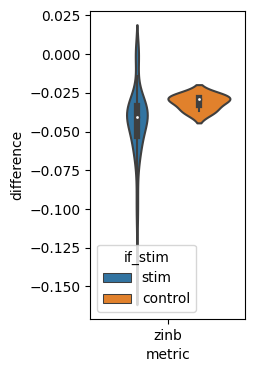

In [10]:
import pandas as pd
import seaborn as sns
df=pd.DataFrame({'difference':differece0, 'if_stim':if_stim0, 'metric':metric0})
plt.figure(figsize=(2, 4))

# box_plot=sns.boxplot(data=df,x="metric", y="difference", hue="if_stim")
# plt.savefig('box-output.png')
# strip_plot=sns.stripplot(data=df,x="metric", y="difference",c='r', hue="if_stim")
# plt.savefig('strip-output.png')
violin_plot=sns.violinplot(data=df,x="metric", y="difference", hue="if_stim")
plt.savefig('violin-output1.png')
